In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("AIS1.csv")

C:\Users\abasu\AppData\Local\Temp\ipykernel_14812\296421141.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("AIS1.csv")


In [5]:
df.head()

,Unnamed: 0,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,...,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D
0,32,01/11/2024 00:00:00,Class A,219000429,54.654167,11.350667,Under way using engine,0.0,0.4,33.2,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
1,34,01/11/2024 00:00:00,Class A,219000429,54.654167,11.350667,Under way using engine,0.0,0.4,33.2,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
2,743,01/11/2024 00:00:03,Class A,211188000,54.599917,11.287717,Under way using engine,1.1,16.2,202.6,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
3,788,01/11/2024 00:00:03,Class A,219000431,54.506467,11.231333,Under way using engine,25.7,10.2,213.4,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
4,791,01/11/2024 00:00:03,Class A,219000431,54.506467,11.231333,Under way using engine,25.7,10.2,213.4,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN


In [8]:
df.drop(columns=["Cargo type"], inplace=True)


In [10]:
df.columns

Index(['Unnamed: 0', '# Timestamp', 'Type of mobile', 'MMSI', 'Latitude',
       'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading',
       'IMO', 'Callsign', 'Name', 'Ship type', 'Width', 'Length',
       'Type of position fixing device', 'Draught', 'Destination', 'ETA',
       'Data source type', 'A', 'B', 'C', 'D'],
      dtype='object')

In [12]:
df.isnull().sum()

Unnamed: 0                             0
# Timestamp                            0
Type of mobile                         0
MMSI                                   0
Latitude                               0
Longitude                              0
Navigational status                    0
ROT                                    3
SOG                                    0
COG                                   41
Heading                                3
IMO                                    0
Callsign                               0
Name                                 735
Ship type                              0
Width                                735
Length                               735
Type of position fixing device         0
Draught                           107713
Destination                            0
ETA                                  735
Data source type                       0
A                                    735
B                                    735
C               

In [14]:
df.fillna({
    'ROT': df['ROT'].median(),
    'COG': df['COG'].median(),
    'Heading': df['Heading'].median(),
    'Draught': df['Draught'].median(),
    'Width': df['Width'].mean(),
    'Length': df['Length'].mean()
}, inplace=True)

In [16]:
df['Name'] = df['Name'].fillna('Unknown')
df['ETA'] = df['ETA'].fillna(df['ETA'].mode()[0])

In [18]:
df.dropna(subset=['ROT', 'COG', 'Heading'], inplace=True)


In [20]:
df[['A', 'B', 'C', 'D']] = df[['A', 'B', 'C', 'D']].fillna(df[['A', 'B', 'C', 'D']].median())


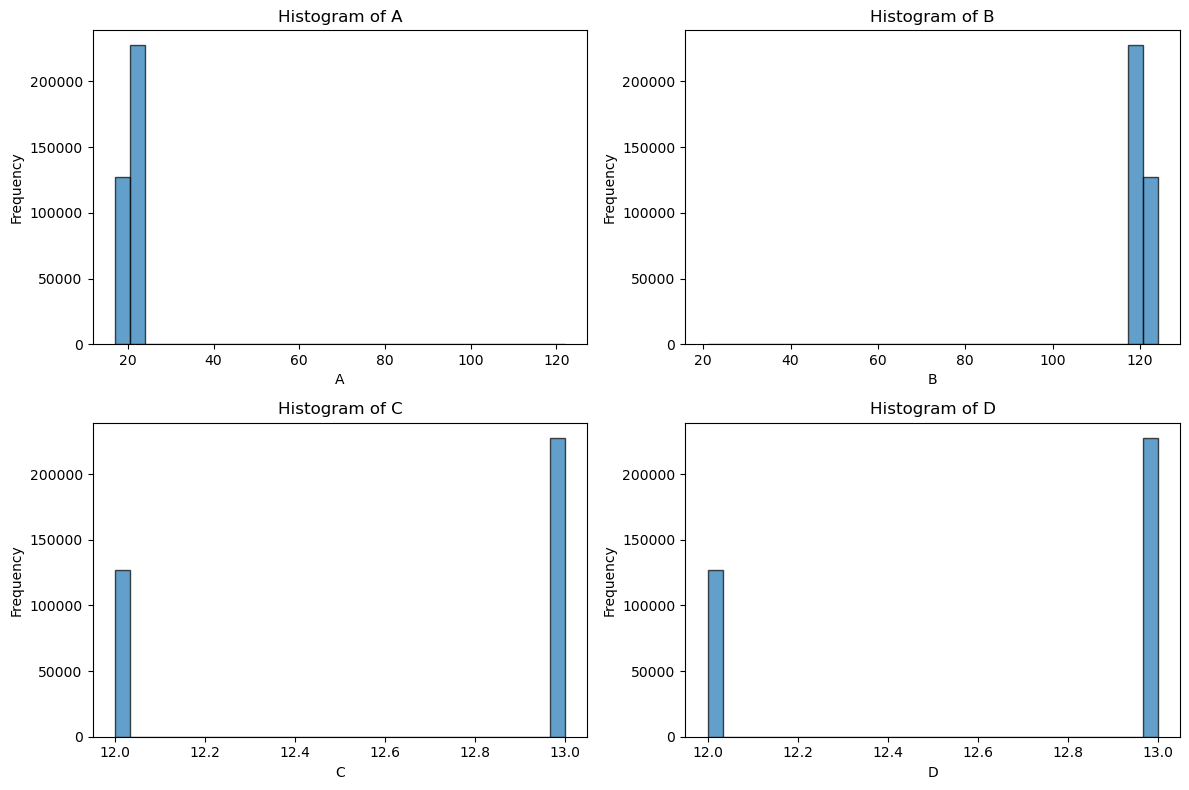

In [22]:
import matplotlib.pyplot as plt

columns = ['A', 'B', 'C', 'D']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes = axes.flatten()

for i, col in enumerate(columns):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [23]:
#feature_engineering

In [24]:
df["# Timestamp"] = pd.to_datetime(df["# Timestamp"], errors="coerce")

In [27]:
df["Hour"] = df["# Timestamp"].dt.hour

In [28]:
df["Day_of_Week"] = df["# Timestamp"].dt.dayofweek
df["Month"] = df["# Timestamp"].dt.month


In [30]:
df["Acceleration"] = df.groupby("MMSI")["SOG"].diff()
df["Change_in_Heading"] = df.groupby("MMSI")["Heading"].diff()
df["Is_Stationary"] = df["SOG"].apply(lambda x: 1 if x < 0.5 else 0)
df["Is_Turning"] = df["ROT"].apply(lambda x: 1 if abs(x) > 20 else 0)


In [34]:
df["ETA"] = pd.to_datetime(df["ETA"], errors="coerce")
df["Time_To_ETA"] = (df["ETA"] - df["# Timestamp"]).dt.total_seconds() / 3600  



C:\Users\abasu\AppData\Local\Temp\ipykernel_14812\2303749625.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["ETA"] = pd.to_datetime(df["ETA"], errors="coerce")


In [36]:
df["Width_Length_Ratio"] = df["Width"] / df["Length"]
df["Draught_Length_Ratio"] = df["Draught"] / df["Length"]


In [38]:
upper_limit = df["SOG"].mean() + 3 * df["SOG"].std()
df["Is_Abnormal_Speed"] = df["SOG"].apply(lambda x: 1 if x > upper_limit else 0)
df["Suspicious_Stop"] = ((df["SOG"] == 0) & (df["Navigational status"] == "Under way using engine")).astype(int)


In [40]:
from geopy.distance import geodesic
def haversine_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

df["Prev_Latitude"] = df.groupby("MMSI")["Latitude"].shift(1)
df["Prev_Longitude"] = df.groupby("MMSI")["Longitude"].shift(1)



In [42]:
print(df[["Prev_Latitude", "Prev_Longitude"]].isnull().sum())


Prev_Latitude     3
Prev_Longitude    3
dtype: int64


In [44]:
df["Prev_Latitude"] = df.groupby("MMSI")["Latitude"].shift(1).fillna(df["Latitude"])
df["Prev_Longitude"] = df.groupby("MMSI")["Longitude"].shift(1).fillna(df["Longitude"])


In [46]:
df.dropna(subset=["Prev_Latitude", "Prev_Longitude"], inplace=True)


In [48]:
df["Distance_Travelled"] = df.apply(lambda row: 
    haversine_distance(row["Latitude"], row["Longitude"], row["Prev_Latitude"], row["Prev_Longitude"]), axis=1)

In [49]:
import numpy as np

def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))
    return np.degrees(np.arctan2(x, y))

df["Bearing"] = df.apply(lambda row: 
    calculate_bearing(row["Prev_Latitude"], row["Prev_Longitude"], row["Latitude"], row["Longitude"]), axis=1)


In [50]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
df["Zone"] = kmeans.fit_predict(df[["Latitude", "Longitude"]])

In [51]:
#EDA

In [52]:

numeric_cols = ["SOG", "COG", "ROT", "Heading", "Draught", "Width", "Length",
                "Acceleration", "Change_in_Heading", "Width_Length_Ratio", "Draught_Length_Ratio", 
                "Time_To_ETA","A","B","C","D"]
categorical_cols = [ "Navigational status", "Ship type", 
                    "Type of position fixing device", "Data source type", "Is_Stationary", 
                    "Is_Moving", "Is_Abnormal_Speed", "Suspicious_Stop"]


In [53]:
df.columns

Index(['Unnamed: 0', '# Timestamp', 'Type of mobile', 'MMSI', 'Latitude',
       'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading',
       'IMO', 'Callsign', 'Name', 'Ship type', 'Width', 'Length',
       'Type of position fixing device', 'Draught', 'Destination', 'ETA',
       'Data source type', 'A', 'B', 'C', 'D', 'Hour', 'Day_of_Week', 'Month',
       'Acceleration', 'Change_in_Heading', 'Is_Stationary', 'Is_Turning',
       'Time_To_ETA', 'Width_Length_Ratio', 'Draught_Length_Ratio',
       'Is_Abnormal_Speed', 'Suspicious_Stop', 'Prev_Latitude',
       'Prev_Longitude', 'Distance_Travelled', 'Bearing', 'Zone'],
      dtype='object')

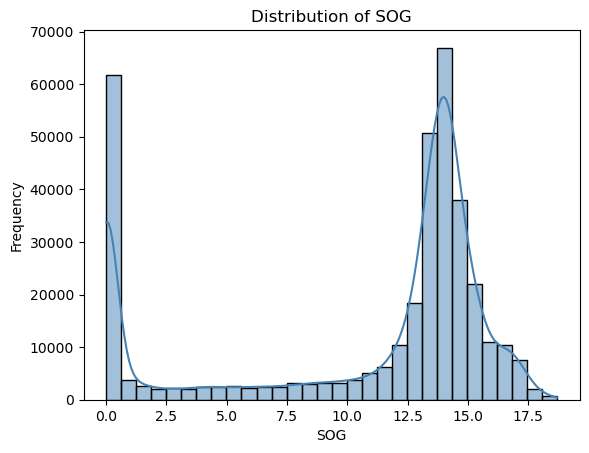

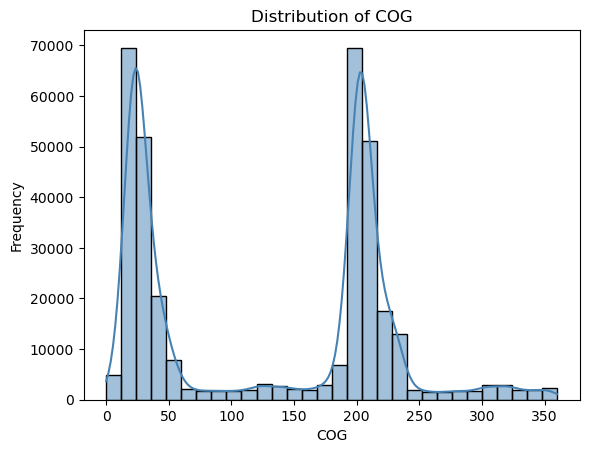

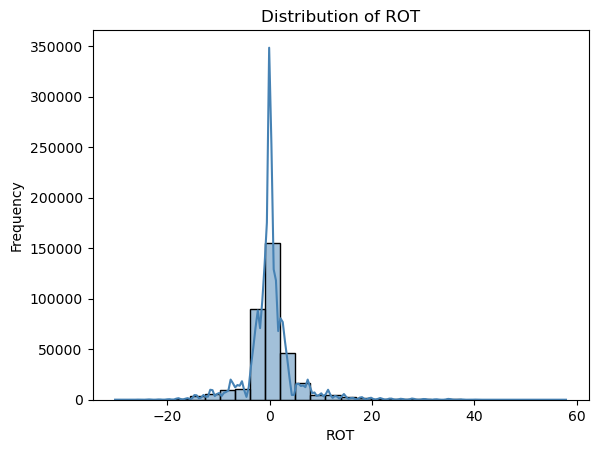

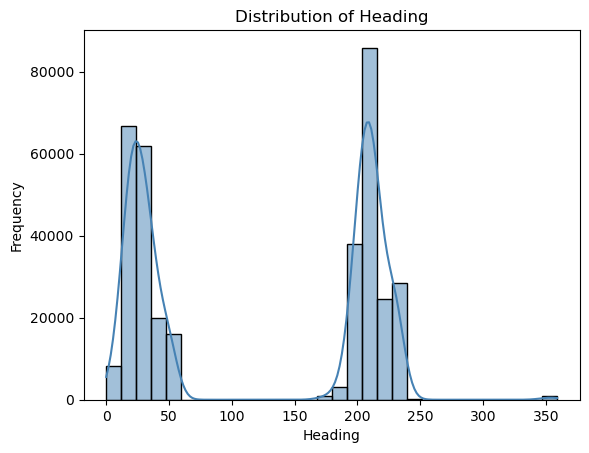

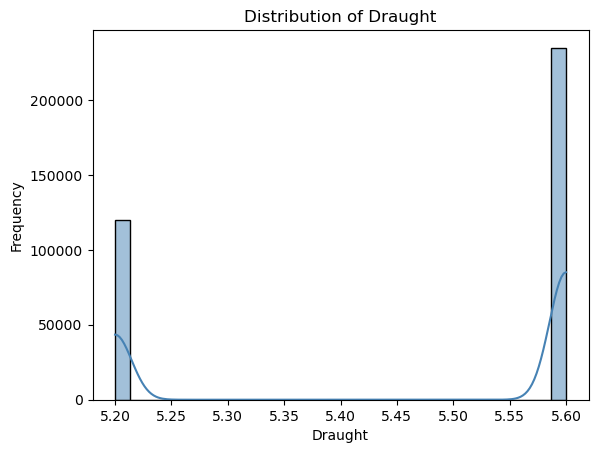

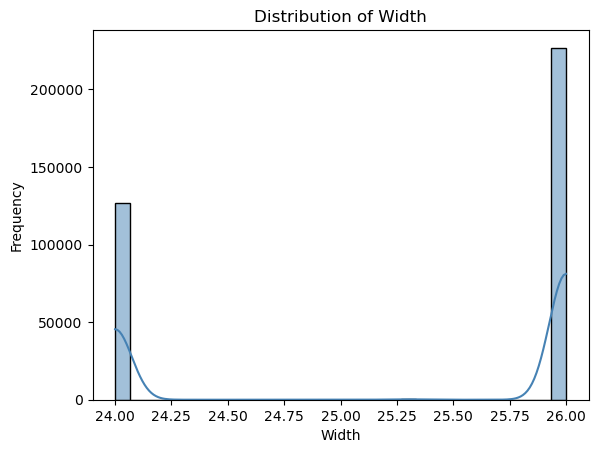

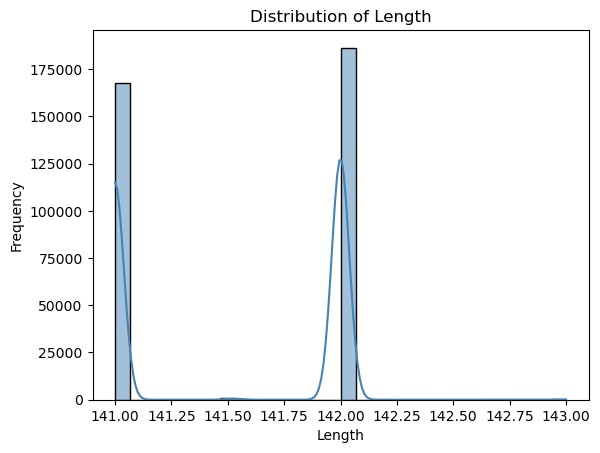

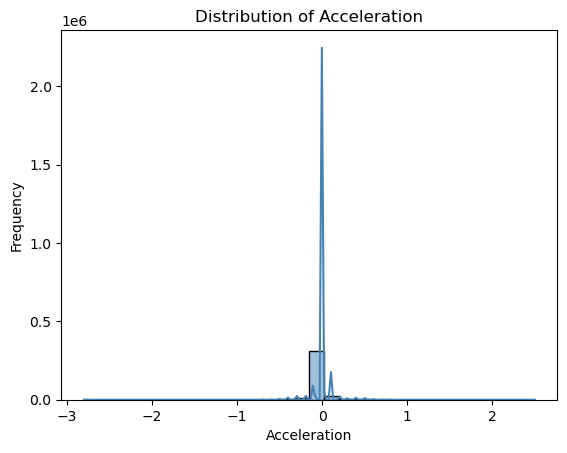

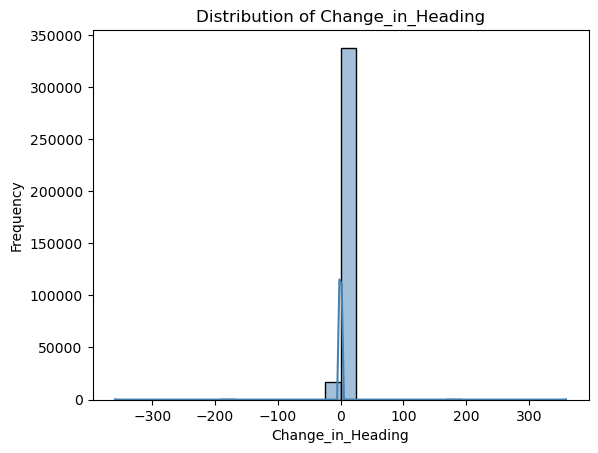

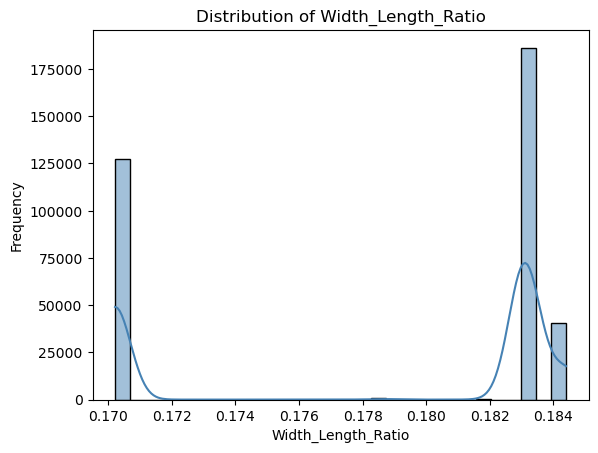

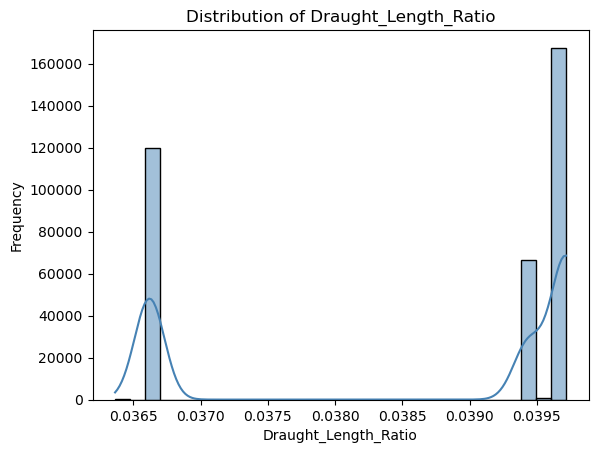

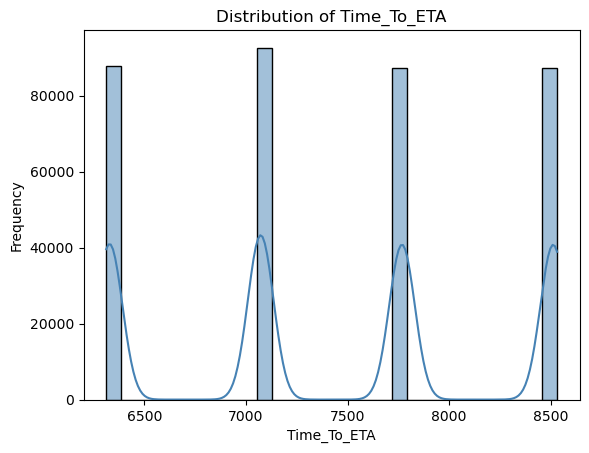

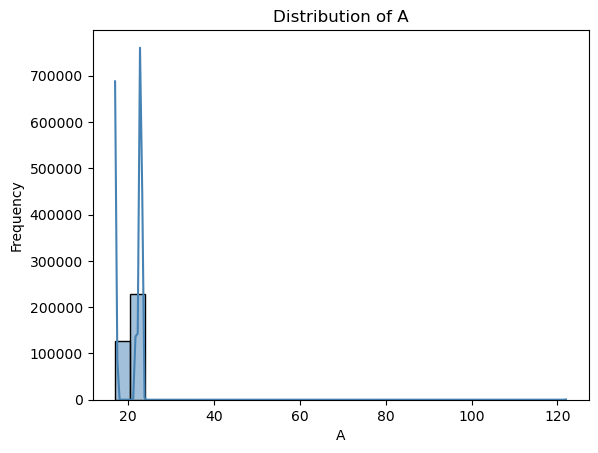

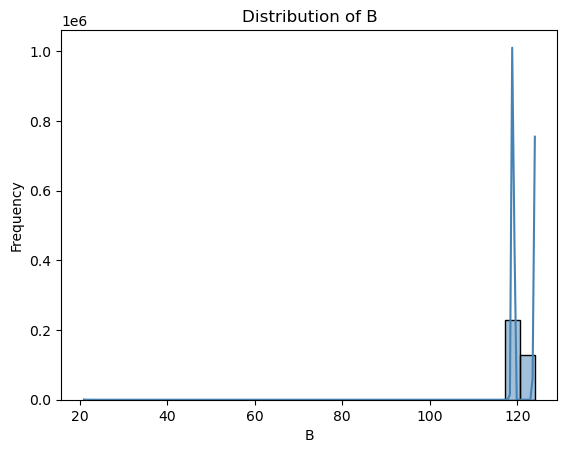

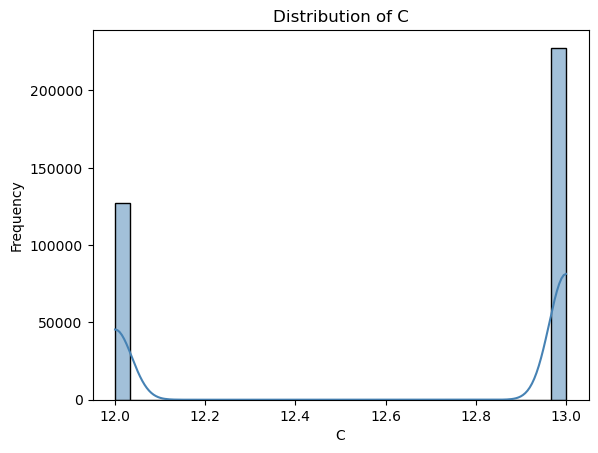

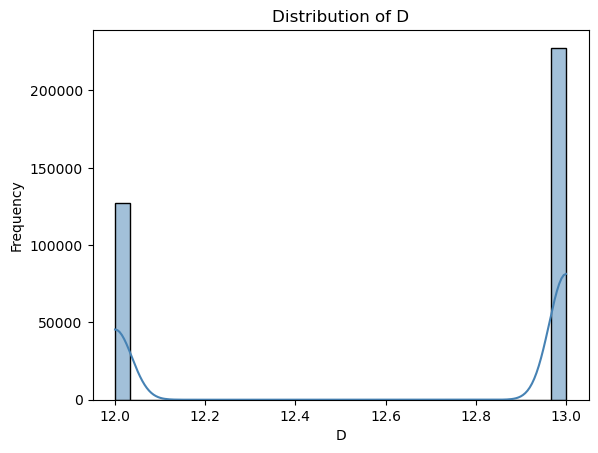

In [54]:
for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], bins=30, kde=True, color="steelblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

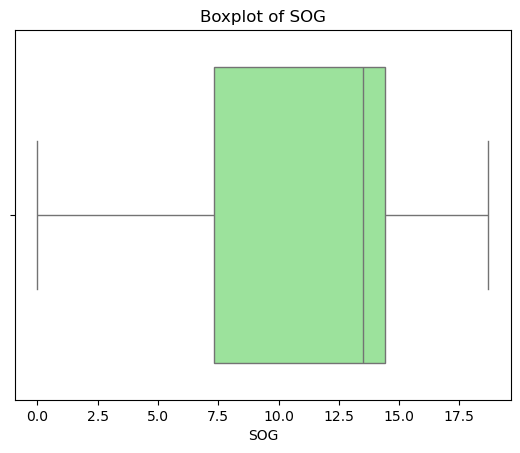

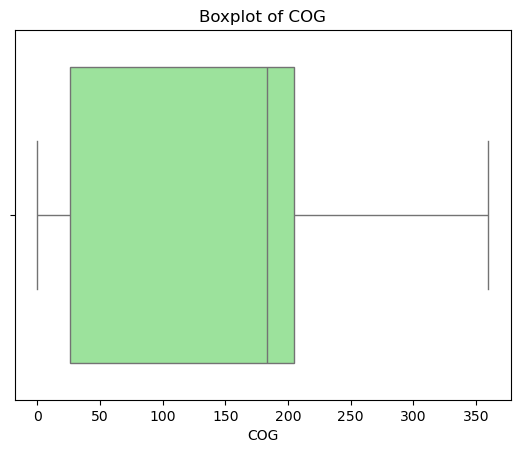

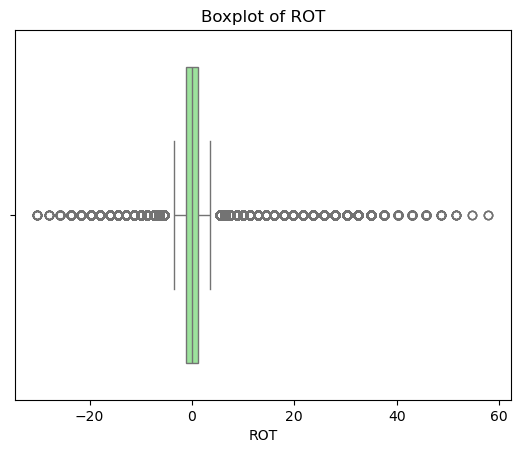

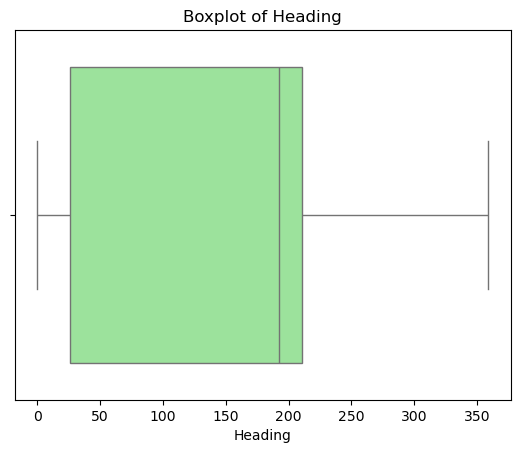

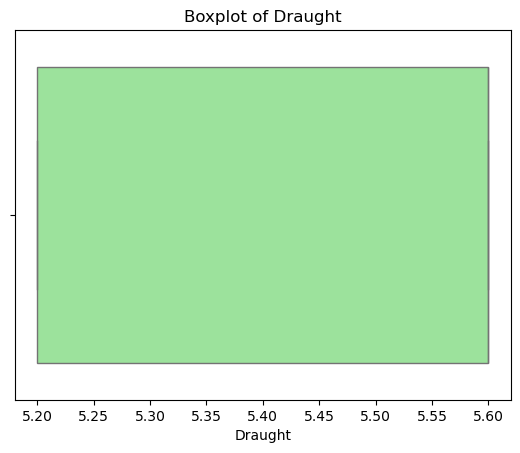

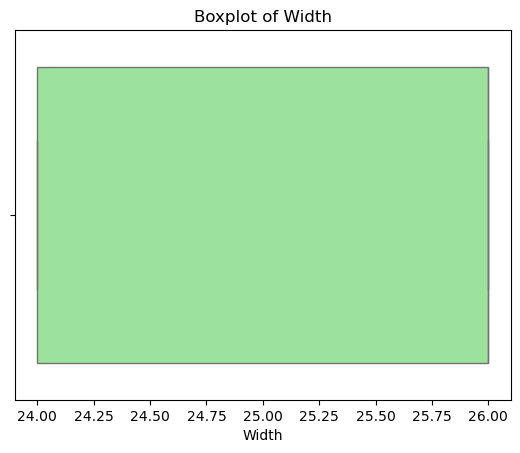

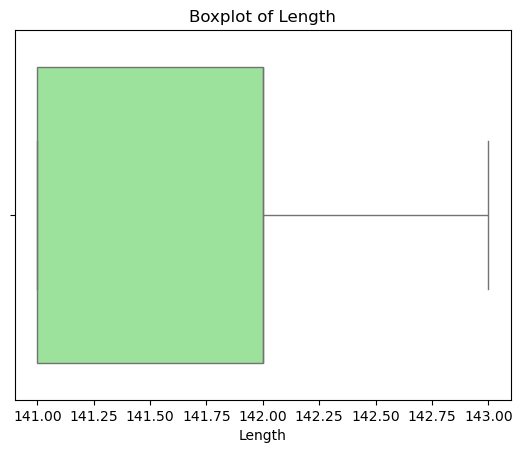

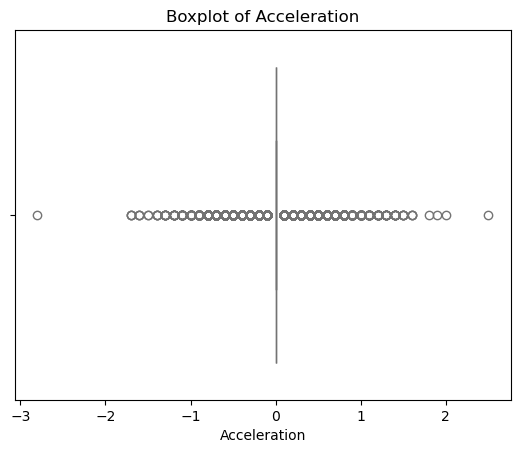

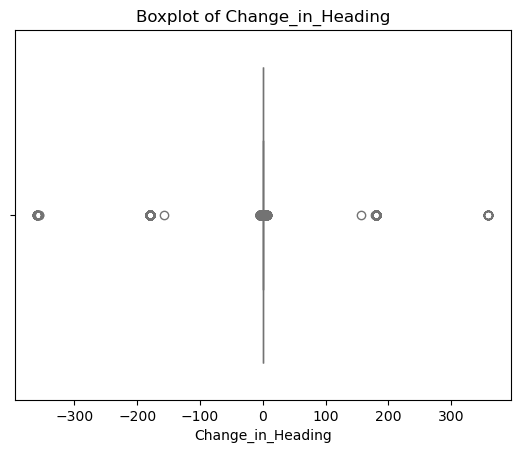

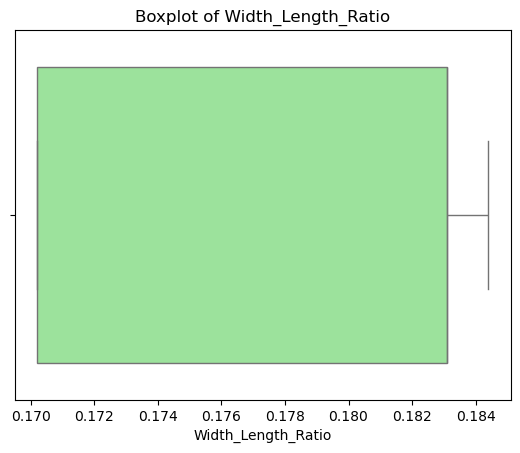

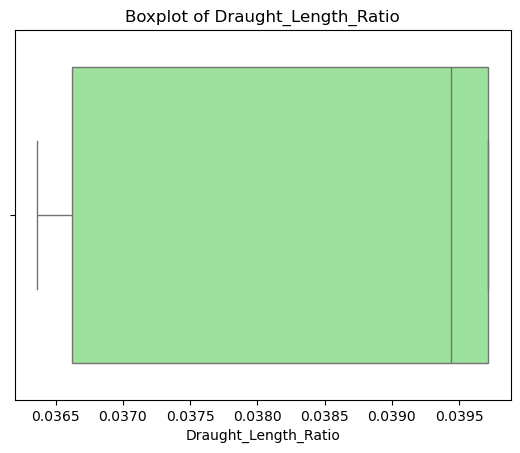

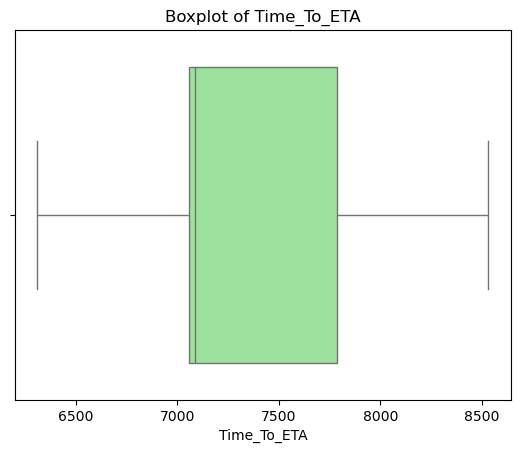

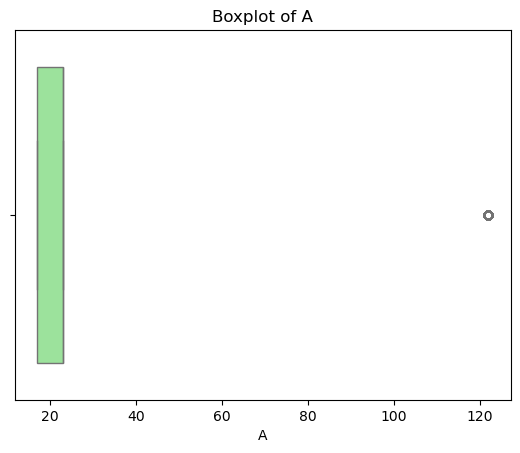

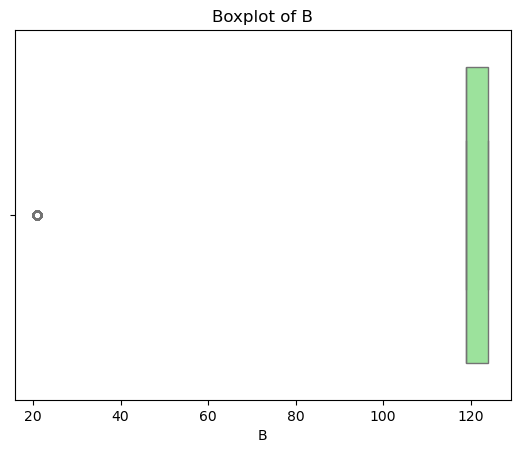

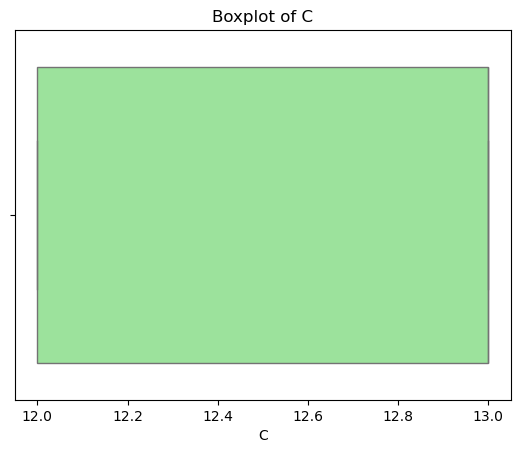

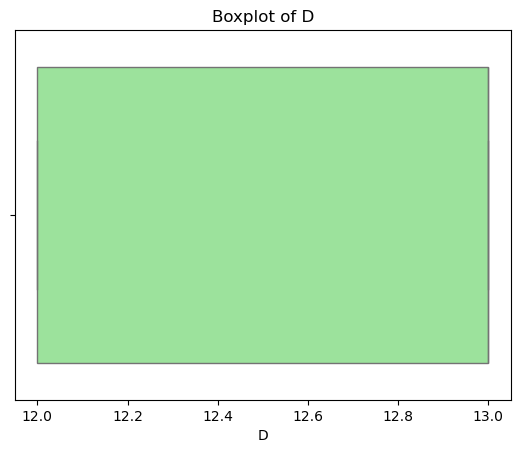

In [33]:
for col in numeric_cols:
    plt.figure()
    sns.boxplot(x=df[col], color="lightgreen")
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\3440315682.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=order, palette="viridis")


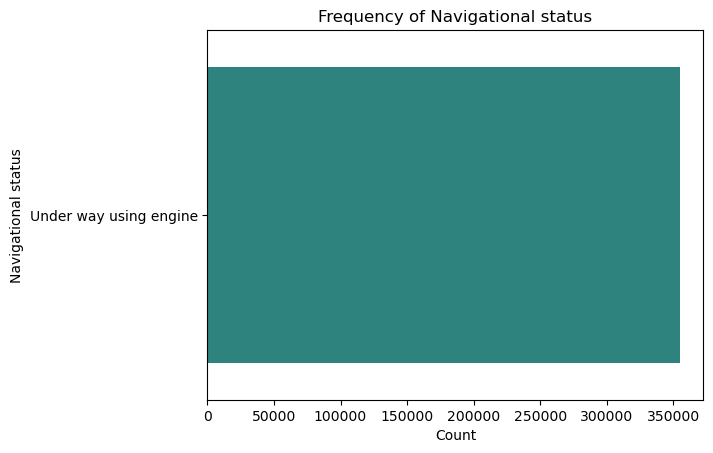

C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\3440315682.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=order, palette="viridis")


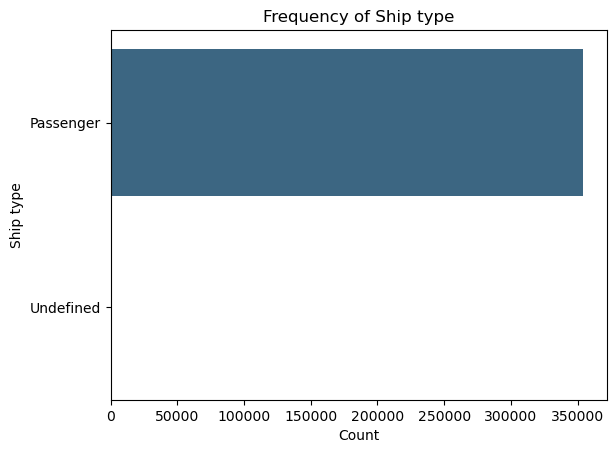

C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\3440315682.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=order, palette="viridis")


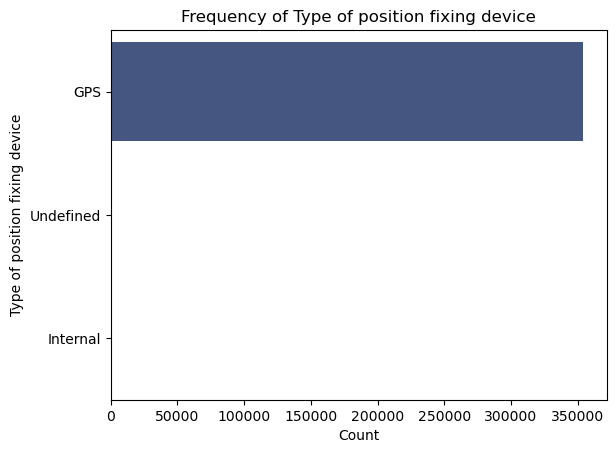

C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\3440315682.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=order, palette="viridis")


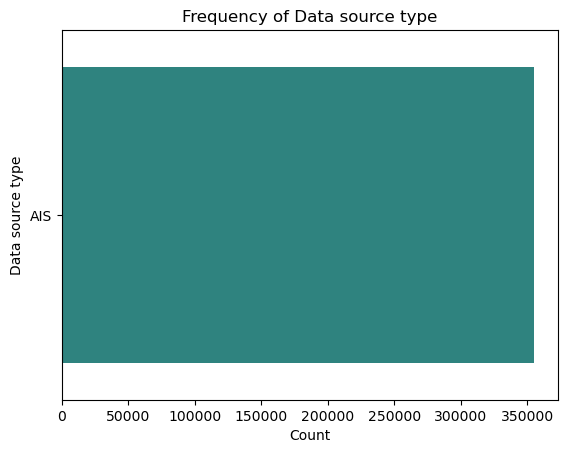

C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\3440315682.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=order, palette="viridis")


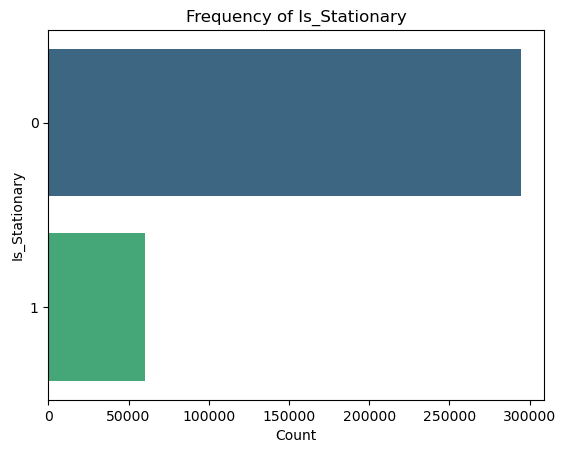

KeyError: 'Is_Moving'

<Figure size 640x480 with 0 Axes>

In [34]:
for col in categorical_cols:
    plt.figure()
    order = df[col].value_counts().index
    sns.countplot(y=col, data=df, order=order, palette="viridis")
    plt.title(f"Frequency of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.show()

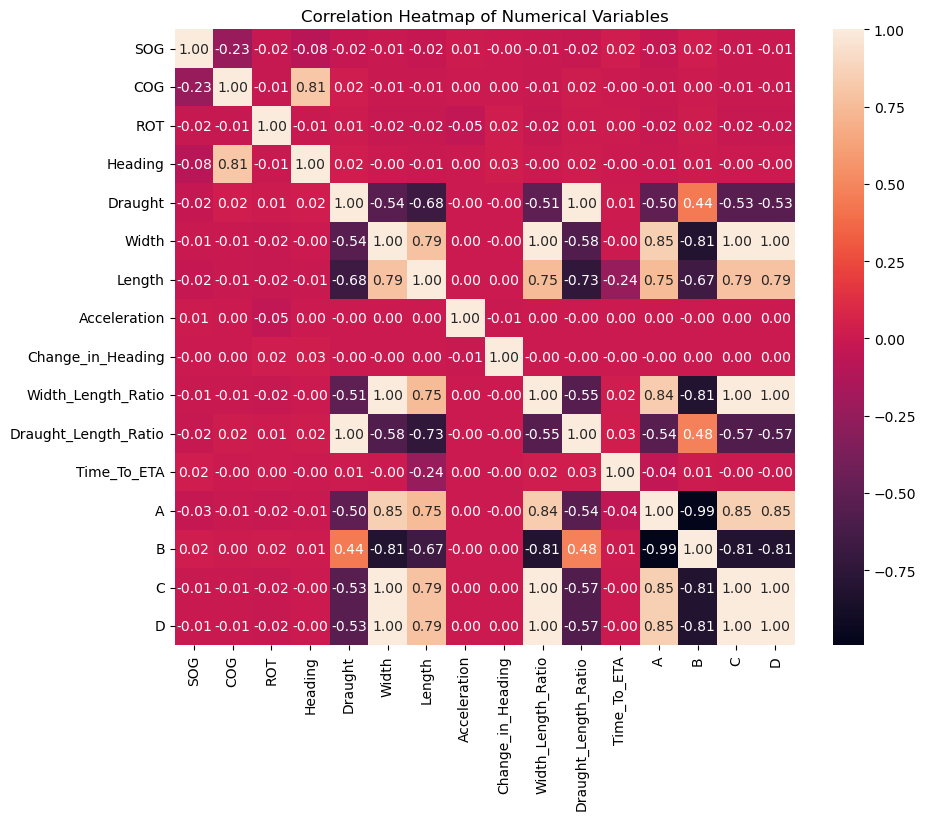

In [35]:
plt.figure(figsize=(10,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True,  fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()

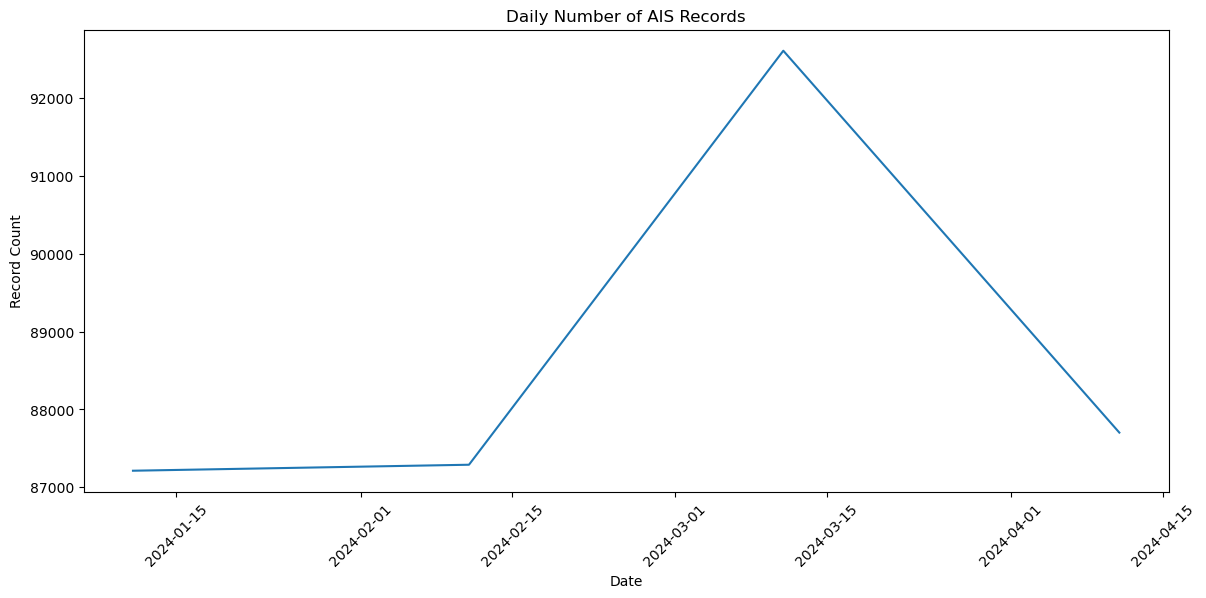

In [37]:
df["Date"] = df["# Timestamp"].dt.date
records_per_day = df.groupby("Date").size()

plt.figure(figsize=(14,6))
records_per_day.plot()
plt.title("Daily Number of AIS Records")
plt.xlabel("Date")
plt.ylabel("Record Count")
plt.xticks(rotation=45)
plt.show()

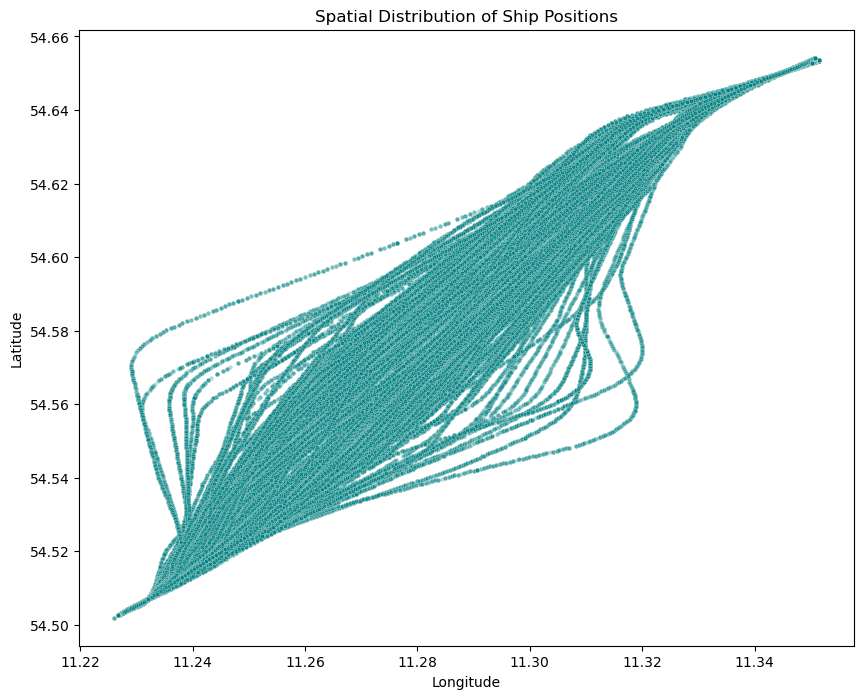

In [38]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="Longitude", y="Latitude", data=df, alpha=0.3, s=10, color="teal")
plt.title("Spatial Distribution of Ship Positions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [39]:
print("Number of Ships with Abnormal Speed:", df["Is_Abnormal_Speed"].sum())
print("Number of Suspicious Stops Detected:", df["Suspicious_Stop"].sum())


Number of Ships with Abnormal Speed: 0
Number of Suspicious Stops Detected: 47868


C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\3353077418.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Is_Abnormal_Speed", data=df, palette="coolwarm")


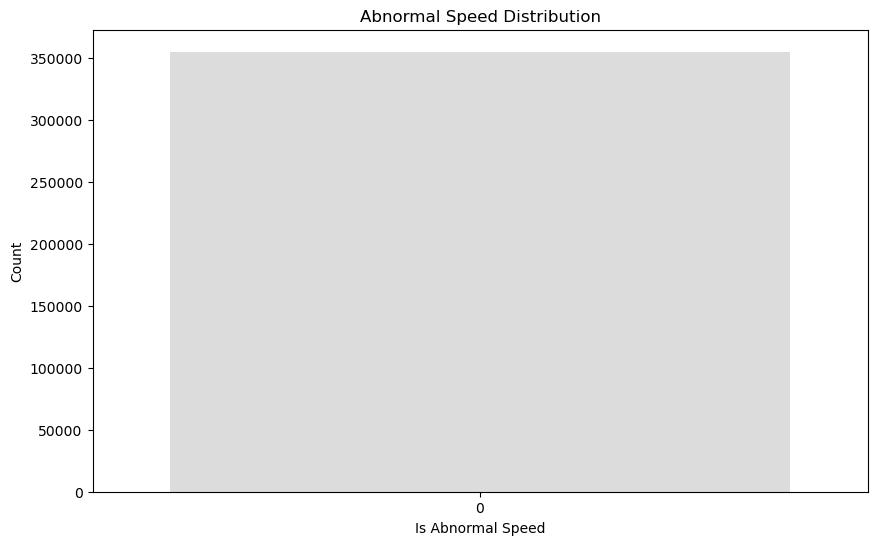

In [40]:
plt.figure(figsize=(10,6))
sns.countplot(x="Is_Abnormal_Speed", data=df, palette="coolwarm")
plt.title("Abnormal Speed Distribution")
plt.xlabel("Is Abnormal Speed")
plt.ylabel("Count")
plt.show()

C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\3621213243.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Suspicious_Stop", data=df, palette="magma")


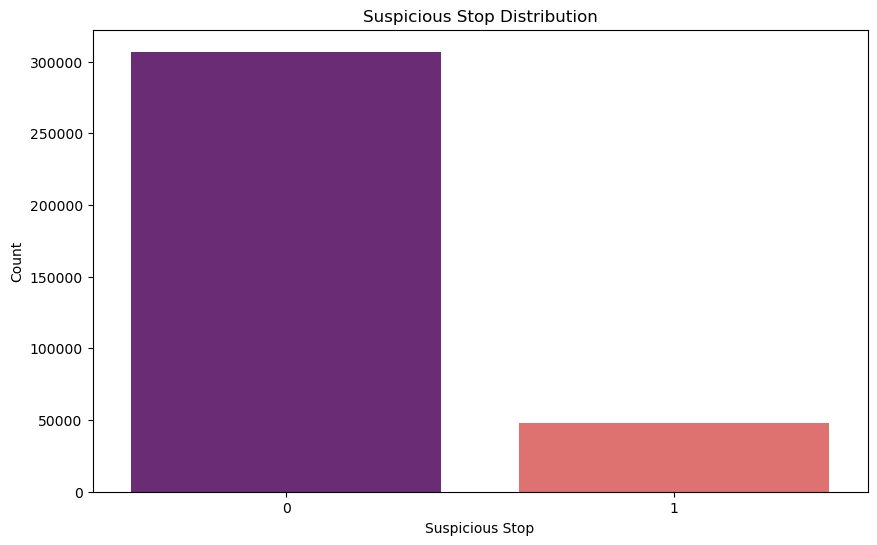

In [41]:
plt.figure(figsize=(10,6))
sns.countplot(x="Suspicious_Stop", data=df, palette="magma")
plt.title("Suspicious Stop Distribution")
plt.xlabel("Suspicious Stop")
plt.ylabel("Count")
plt.show()

In [42]:
corr = df[numeric_cols].corr()

In [43]:


corr_matrix = df[numeric_cols].corr()

high_corr_pairs = corr_matrix.unstack().reset_index()
high_corr_pairs.columns = ["Variable_1", "Variable_2", "Correlation"]
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs["Correlation"]) > 0.7]

high_corr_pairs = high_corr_pairs[high_corr_pairs["Variable_1"] != high_corr_pairs["Variable_2"]]

print(high_corr_pairs)


               Variable_1            Variable_2  Correlation
19                    COG               Heading     0.808731
49                Heading                   COG     0.808731
74                Draught  Draught_Length_Ratio     0.997423
86                  Width                Length     0.788932
89                  Width    Width_Length_Ratio     0.997996
92                  Width                     A     0.845640
93                  Width                     B    -0.813835
94                  Width                     C     0.999420
95                  Width                     D     0.999420
101                Length                 Width     0.788932
105                Length    Width_Length_Ratio     0.748472
106                Length  Draught_Length_Ratio    -0.728969
108                Length                     A     0.745285
110                Length                     C     0.788475
111                Length                     D     0.788475
149    Width_Length_Rati

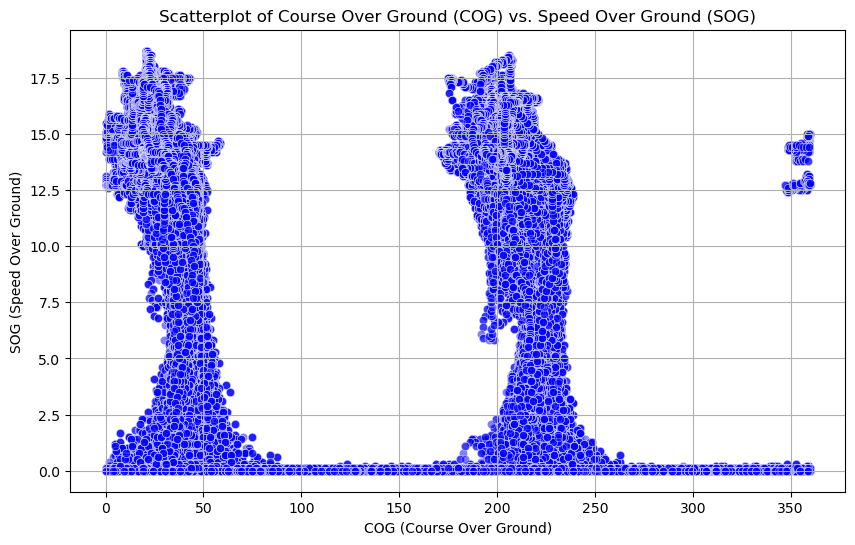

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["COG"], y=df["SOG"], alpha=0.5, color="blue")
plt.title("Scatterplot of Course Over Ground (COG) vs. Speed Over Ground (SOG)")
plt.xlabel("COG (Course Over Ground)")
plt.ylabel("SOG (Speed Over Ground)")
plt.grid()
plt.show()

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

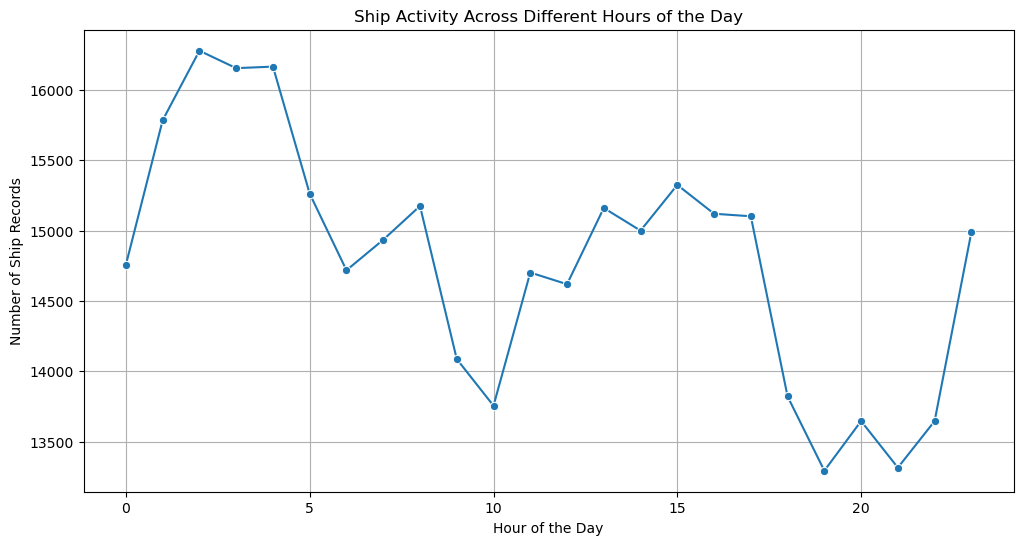

In [46]:
hourly_ship_counts = df.groupby("Hour").size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_ship_counts.index, y=hourly_ship_counts.values, marker="o")
plt.title("Ship Activity Across Different Hours of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Ship Records")
plt.grid()
plt.show()

In [47]:
df.columns

Index(['Unnamed: 0', '# Timestamp', 'Type of mobile', 'MMSI', 'Latitude',
       'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading',
       'IMO', 'Callsign', 'Name', 'Ship type', 'Width', 'Length',
       'Type of position fixing device', 'Draught', 'Destination', 'ETA',
       'Data source type', 'A', 'B', 'C', 'D', 'Hour', 'Day_of_Week', 'Month',
       'Acceleration', 'Change_in_Heading', 'Is_Stationary', 'Is_Turning',
       'Time_To_ETA', 'Width_Length_Ratio', 'Draught_Length_Ratio',
       'Is_Abnormal_Speed', 'Suspicious_Stop', 'Prev_Latitude',
       'Prev_Longitude', 'Distance_Travelled', 'Bearing', 'Zone', 'Date'],
      dtype='object')

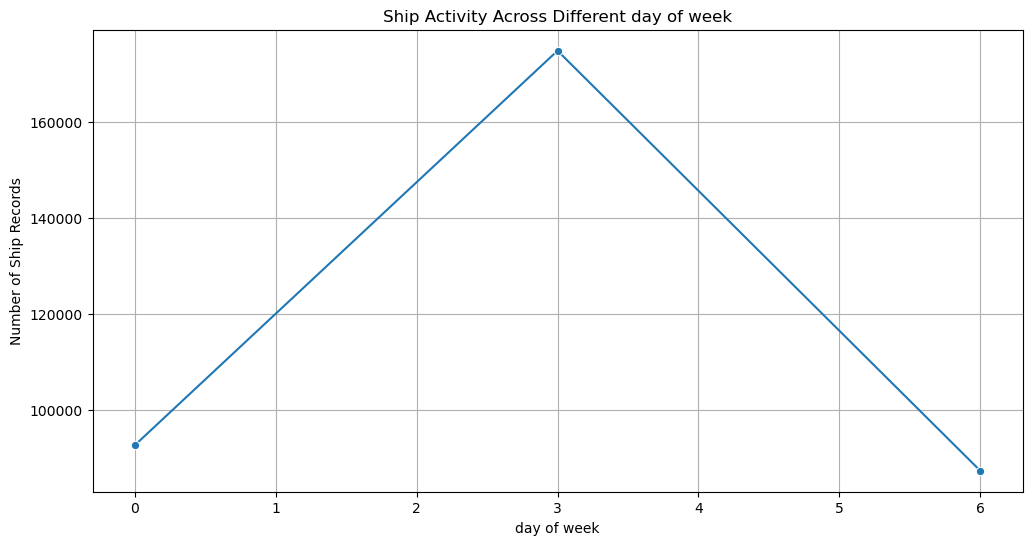

In [48]:
weekly_ship_counts = df.groupby("Day_of_Week").size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=weekly_ship_counts.index, y=weekly_ship_counts.values, marker="o")
plt.title("Ship Activity Across Different day of week")
plt.xlabel("day of week")
plt.ylabel("Number of Ship Records")
plt.grid()
plt.show()

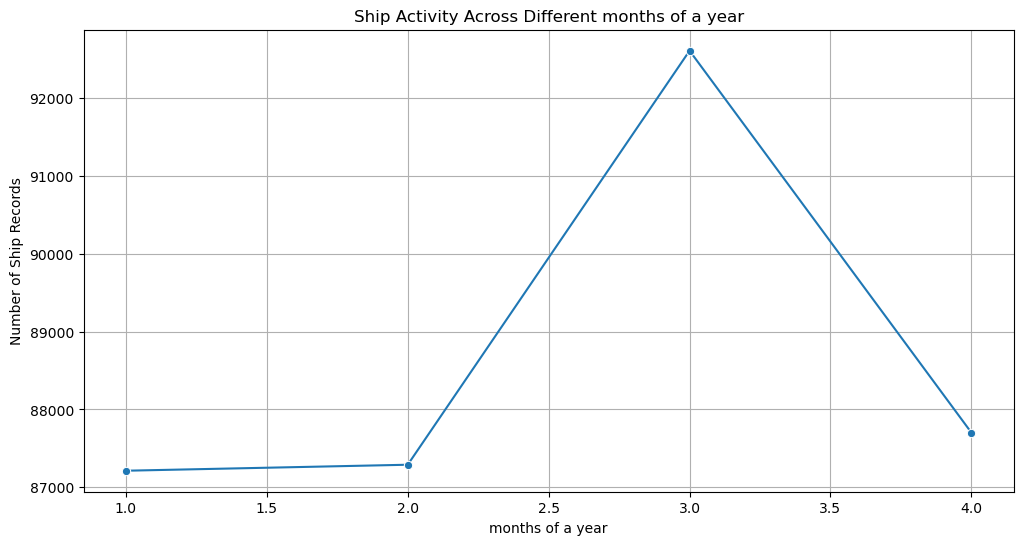

In [49]:
monthly_ship_counts = df.groupby("Month").size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_ship_counts.index, y=monthly_ship_counts.values, marker="o")
plt.title("Ship Activity Across Different months of a year")
plt.xlabel("months of a year")
plt.ylabel("Number of Ship Records")
plt.grid()
plt.show()

C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\838010214.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Abnormal Speed", "Abnormal Turn", "Suspicious Stop"],


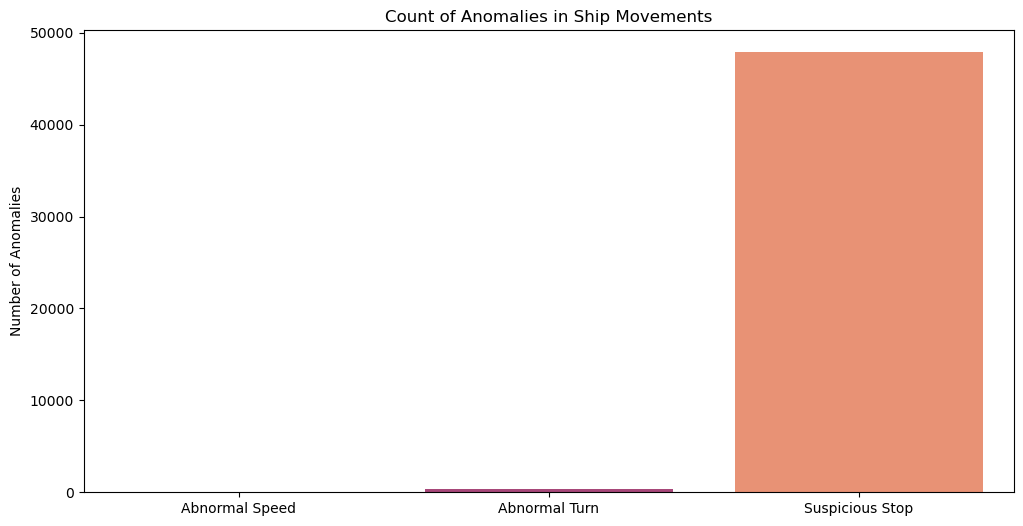

In [51]:
df["Abnormal_Speed"] = (df["SOG"] > df["SOG"].mean() + 3 * df["SOG"].std()).astype(int)
df["Abnormal_Turn"] = (abs(df["Change_in_Heading"]) > df["Change_in_Heading"].mean() + 3 * df["Change_in_Heading"].std()).astype(int)
df["Suspicious_Stop"] = ((df["SOG"] == 0) & (df["Navigational status"] == "Under way using engine")).astype(int)

plt.figure(figsize=(12,6))
sns.barplot(x=["Abnormal Speed", "Abnormal Turn", "Suspicious Stop"], 
            y=[df["Abnormal_Speed"].sum(), df["Abnormal_Turn"].sum(), df["Suspicious_Stop"].sum()],
            palette="magma")
plt.title("Count of Anomalies in Ship Movements")
plt.ylabel("Number of Anomalies")
plt.show()

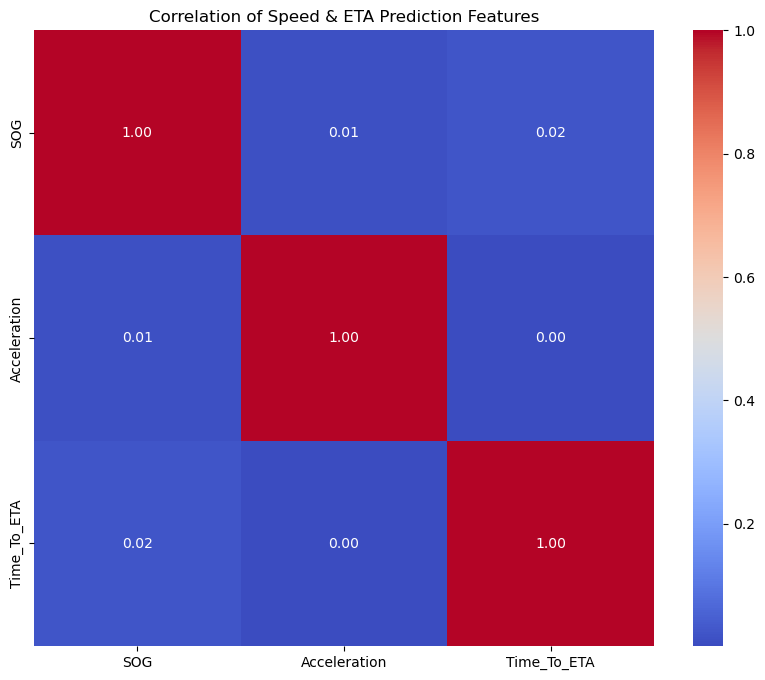

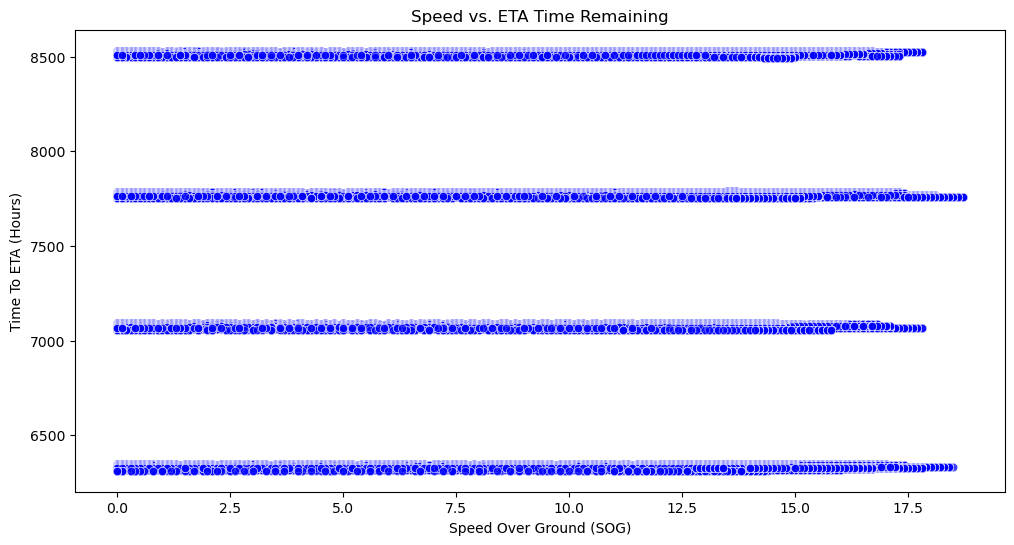

In [57]:
plt.figure(figsize=(10,8))
sns.heatmap(df[["SOG", "Acceleration", "Time_To_ETA"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Speed & ETA Prediction Features")
plt.show()

plt.figure(figsize=(12,6))
sns.scatterplot(x="SOG", y="Time_To_ETA", data=df, alpha=0.5, color="blue")
plt.title("Speed vs. ETA Time Remaining")
plt.xlabel("Speed Over Ground (SOG)")
plt.ylabel("Time To ETA (Hours)")
plt.show()

In [62]:
columns_to_clean = ["SOG", "ROT", "Acceleration", "Change_in_Heading", "Width_Length_Ratio"]

df = df.dropna(subset=columns_to_clean)

print(df[columns_to_clean].isnull().sum())

SOG                   0
ROT                   0
Acceleration          0
Change_in_Heading     0
Width_Length_Ratio    0
dtype: int64


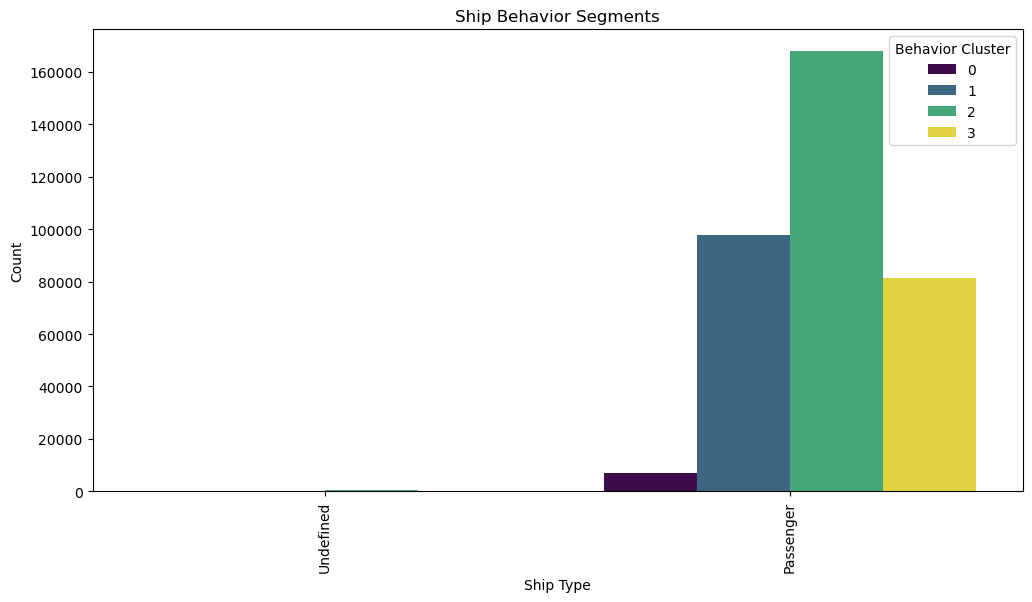

In [66]:
clustering_features = ["SOG", "ROT", "Acceleration", "Change_in_Heading", "Width_Length_Ratio"]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[clustering_features])

kmeans = KMeans(n_clusters=4, random_state=42)
df["Behavior_Cluster"] = kmeans.fit_predict(df_scaled)

plt.figure(figsize=(12,6))
sns.countplot(x="Ship type", hue="Behavior_Cluster", data=df, palette="viridis")
plt.title("Ship Behavior Segments")
plt.xlabel("Ship Type")
plt.ylabel("Count")
plt.legend(title="Behavior Cluster")
plt.xticks(rotation=90)
plt.show()

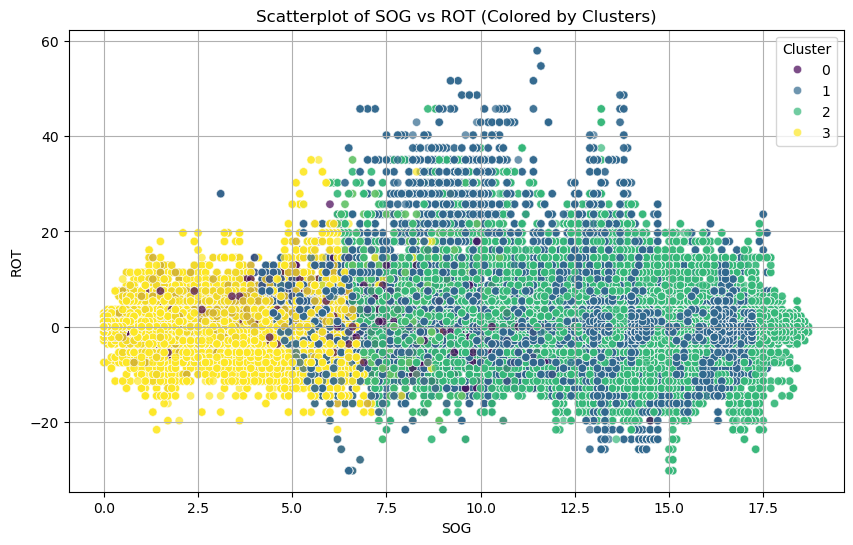

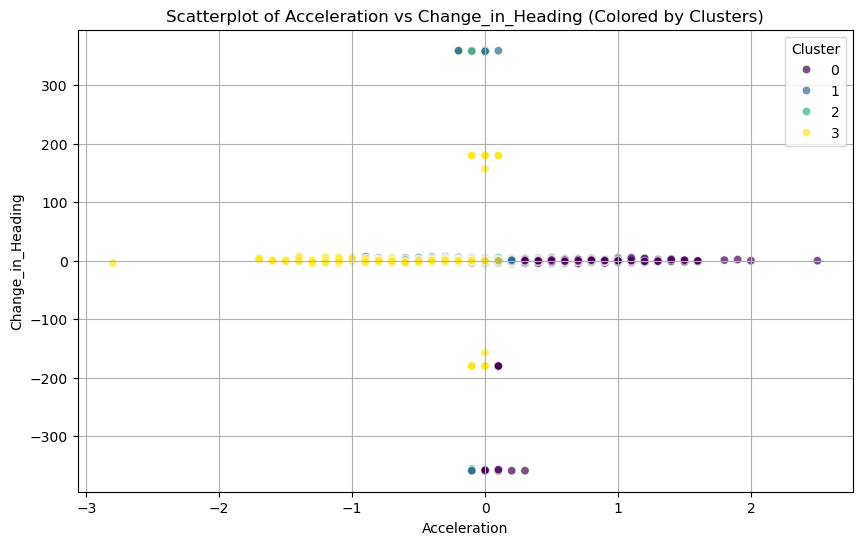

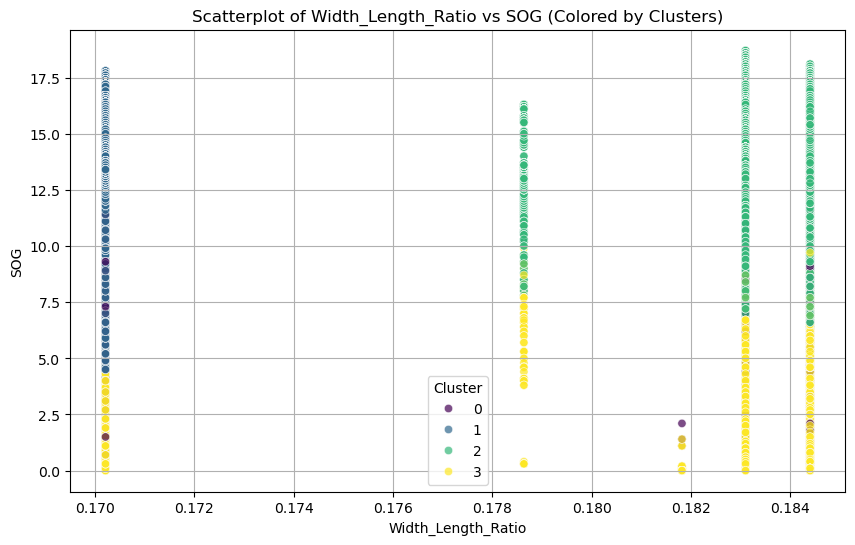

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

scatterplot_pairs = [
    ("SOG", "ROT"),
    ("Acceleration", "Change_in_Heading"),
    ("Width_Length_Ratio", "SOG")
]

for x_feat, y_feat in scatterplot_pairs:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[x_feat], y=df[y_feat], hue=df["Behavior_Cluster"], palette="viridis", alpha=0.7)
    plt.title(f"Scatterplot of {x_feat} vs {y_feat} (Colored by Clusters)")
    plt.xlabel(x_feat)
    plt.ylabel(y_feat)
    plt.legend(title="Cluster")
    plt.grid()
    plt.show()


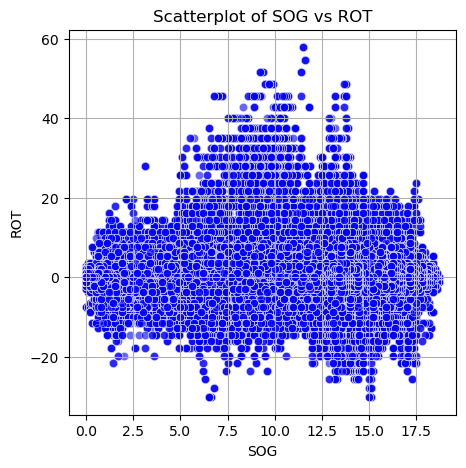

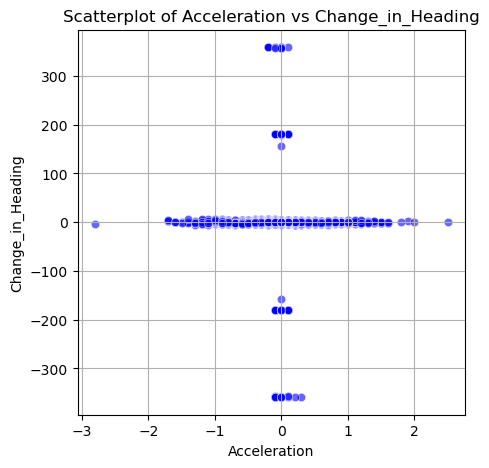

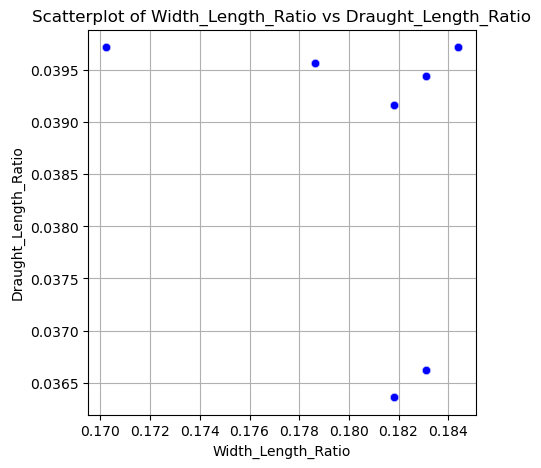

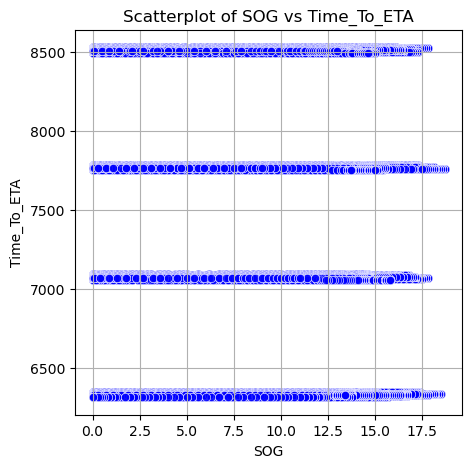

In [72]:


significant_scatter_pairs = [
    ("SOG", "ROT"),  # Speed vs. Rate of Turn
    ("Acceleration", "Change_in_Heading"),  # Acceleration vs. Heading Change
    ("Width_Length_Ratio", "Draught_Length_Ratio"),  # Ship Size Ratios
    ("SOG", "Time_To_ETA")  # Speed vs. Estimated Time of Arrival
]

for x_feat, y_feat in significant_scatter_pairs:
    plt.figure(figsize=(5,5))
    sns.scatterplot(x=df[x_feat], y=df[y_feat], alpha=0.6, color="blue")
    plt.title(f"Scatterplot of {x_feat} vs {y_feat}")
    plt.xlabel(x_feat)
    plt.ylabel(y_feat)
    plt.grid()
    plt.show()


In [74]:
df.columns

Index(['Unnamed: 0', '# Timestamp', 'Type of mobile', 'MMSI', 'Latitude',
       'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading',
       'IMO', 'Callsign', 'Name', 'Ship type', 'Width', 'Length',
       'Type of position fixing device', 'Draught', 'Destination', 'ETA',
       'Data source type', 'A', 'B', 'C', 'D', 'Hour', 'Day_of_Week', 'Month',
       'Acceleration', 'Change_in_Heading', 'Is_Stationary', 'Is_Turning',
       'Time_To_ETA', 'Width_Length_Ratio', 'Draught_Length_Ratio',
       'Is_Abnormal_Speed', 'Suspicious_Stop', 'Prev_Latitude',
       'Prev_Longitude', 'Distance_Travelled', 'Bearing', 'Zone', 'Date',
       'Abnormal_Speed', 'Abnormal_Turn', 'Behavior_Cluster'],
      dtype='object')

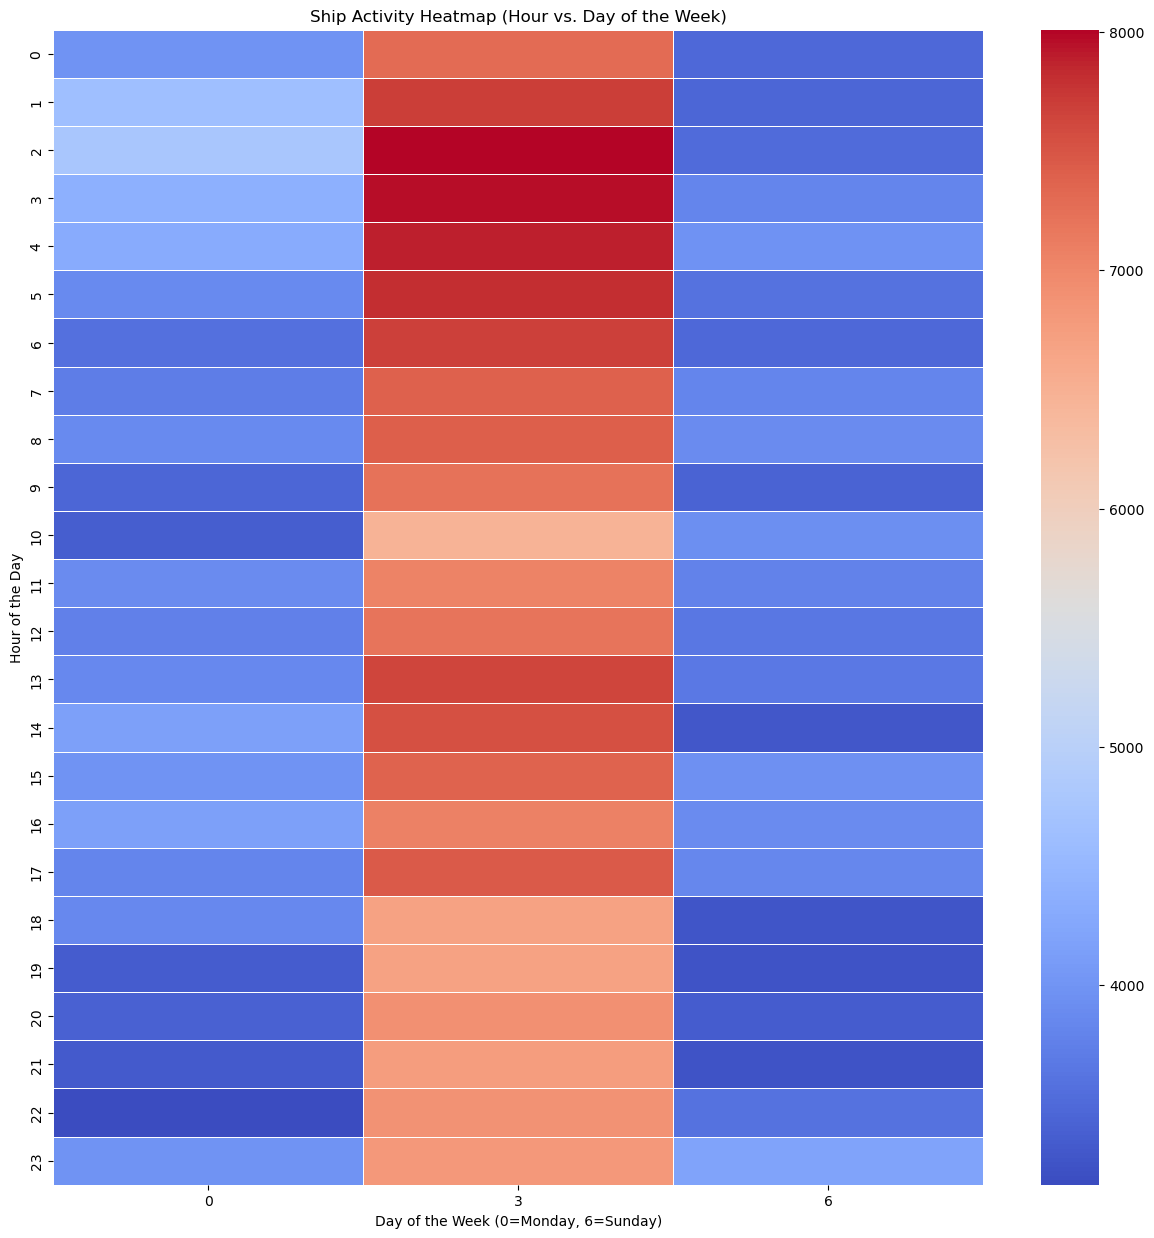

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt




plt.figure(figsize=(15,15))
ship_activity_pivot = df.pivot_table(index="Hour", columns="Day_of_Week", values="MMSI", aggfunc="count")
sns.heatmap(ship_activity_pivot, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Ship Activity Heatmap (Hour vs. Day of the Week)")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Hour of the Day")
plt.show()


C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\3449273530.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=time_of_day_analysis.index, y=time_of_day_analysis.values, palette="viridis")


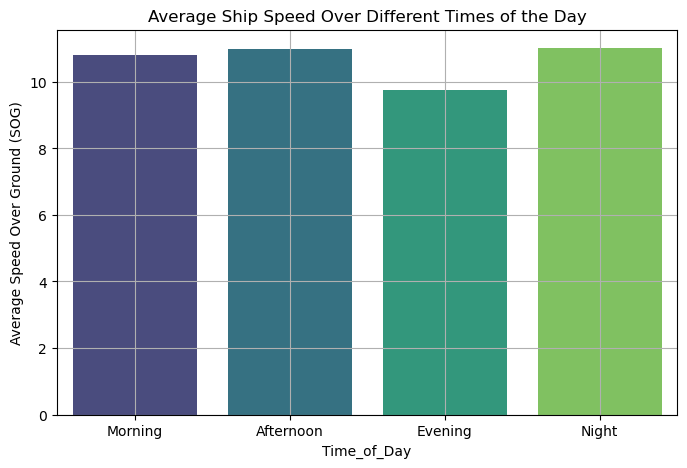

In [82]:
df["Time_of_Day"] = df["Hour"].apply(lambda x: "Morning" if 6 <= x < 12 
                                     else "Afternoon" if 12 <= x < 18
                                     else "Evening" if 18 <= x < 24 
                                     else "Night")

time_of_day_analysis = df.groupby("Time_of_Day")["SOG"].mean().reindex(["Morning", "Afternoon", "Evening", "Night"])

plt.figure(figsize=(8, 5))
sns.barplot(x=time_of_day_analysis.index, y=time_of_day_analysis.values, palette="viridis")
plt.title("Average Ship Speed Over Different Times of the Day")
plt.ylabel("Average Speed Over Ground (SOG)")
plt.grid()
plt.show()


C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\4131466562.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="High_Risk", data=df, palette="magma")


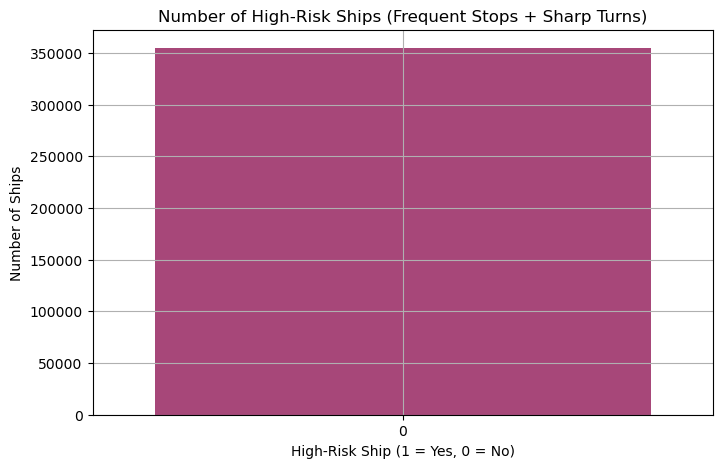

In [86]:
df["High_Risk"] = ((df["SOG"] < 1) & (df["ROT"] > 30)).astype(int)

# Countplot of high-risk ships
plt.figure(figsize=(8, 5))
sns.countplot(x="High_Risk", data=df, palette="magma")
plt.title("Number of High-Risk Ships (Frequent Stops + Sharp Turns)")
plt.xlabel("High-Risk Ship (1 = Yes, 0 = No)")
plt.ylabel("Number of Ships")
plt.grid()
plt.show()

C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\1669881567.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




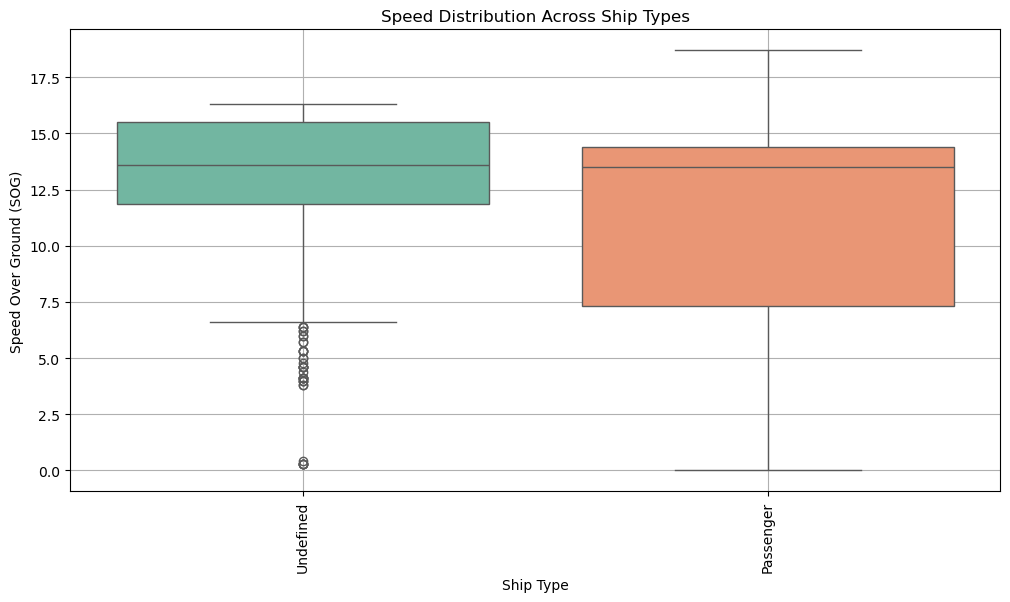

In [92]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Ship type", y="SOG", data=df, palette="Set2")
plt.title("Speed Distribution Across Ship Types")
plt.xlabel("Ship Type")
plt.ylabel("Speed Over Ground (SOG)")
plt.xticks(rotation=90)
plt.grid()
plt.show()

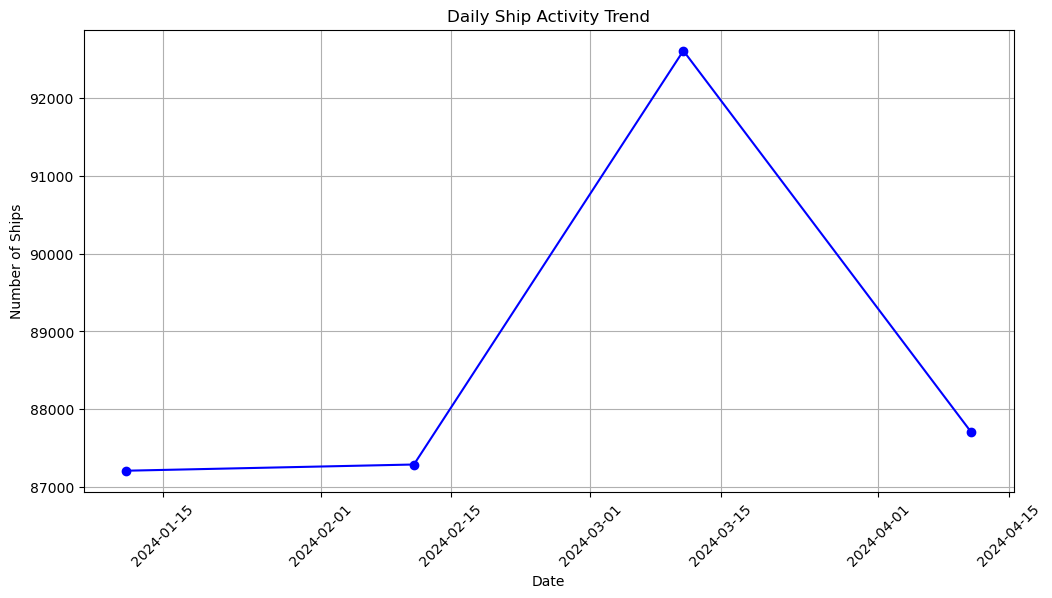

In [94]:
df["Date"] = df["# Timestamp"].dt.date
ship_activity = df.groupby("Date")["MMSI"].count()

# Plot ship activity trend
plt.figure(figsize=(12, 6))
plt.plot(ship_activity.index, ship_activity.values, marker="o", linestyle="-", color="blue")
plt.title("Daily Ship Activity Trend")
plt.xlabel("Date")
plt.ylabel("Number of Ships")
plt.xticks(rotation=45)
plt.grid()
plt.show()

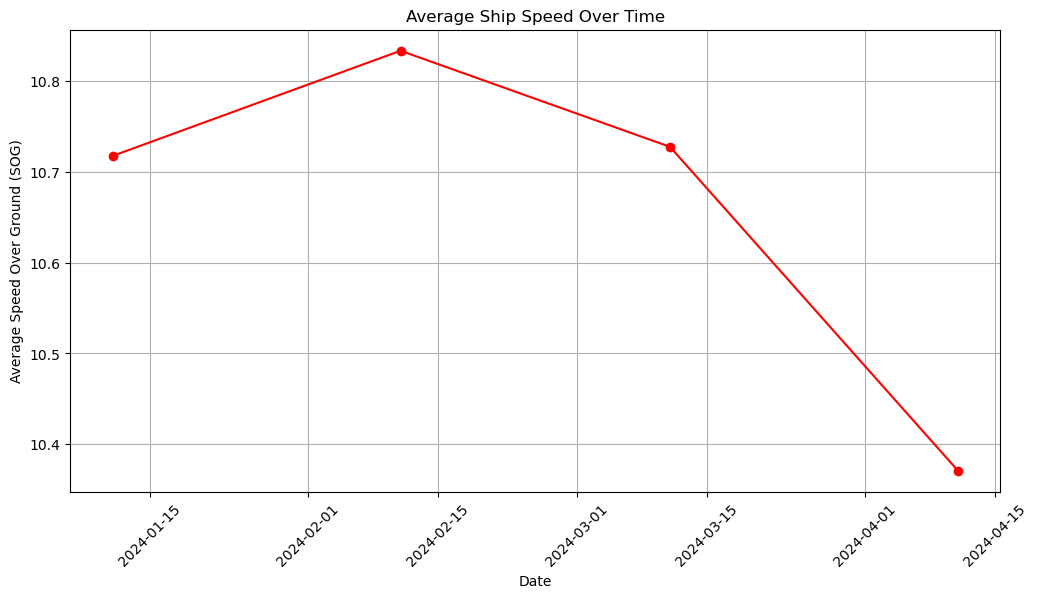

In [96]:
speed_trend = df.groupby("Date")["SOG"].mean()

# Plot speed trends
plt.figure(figsize=(12, 6))
plt.plot(speed_trend.index, speed_trend.values, marker="o", linestyle="-", color="red")
plt.title("Average Ship Speed Over Time")
plt.xlabel("Date")
plt.ylabel("Average Speed Over Ground (SOG)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [98]:
from statsmodels.tsa.arima.model import ARIMA





C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\566475202.py:5: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



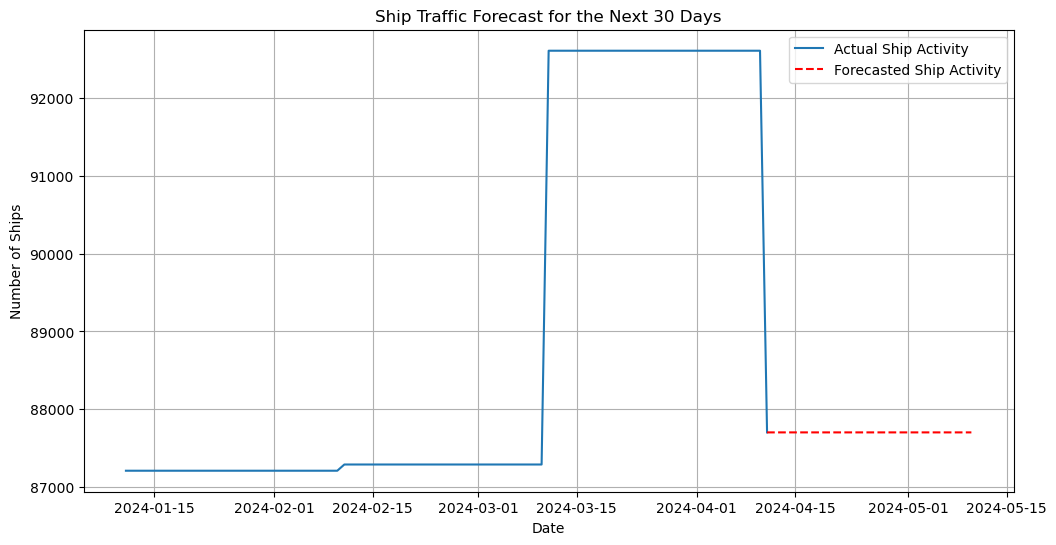

In [100]:
from statsmodels.tsa.arima.model import ARIMA

ship_activity = df.groupby("Date")["MMSI"].count()
ship_activity = ship_activity.asfreq("D").fillna(method="ffill")  

model = ARIMA(ship_activity, order=(5,1,0)) 
model_fit = model.fit()

forecast = model_fit.forecast(steps=30)

plt.figure(figsize=(12,6))
plt.plot(ship_activity.index, ship_activity.values, label="Actual Ship Activity")
plt.plot(pd.date_range(start=ship_activity.index[-1], periods=30, freq="D"), forecast, linestyle="dashed", color="red", label="Forecasted Ship Activity")
plt.title("Ship Traffic Forecast for the Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Number of Ships")
plt.legend()
plt.grid()
plt.show()


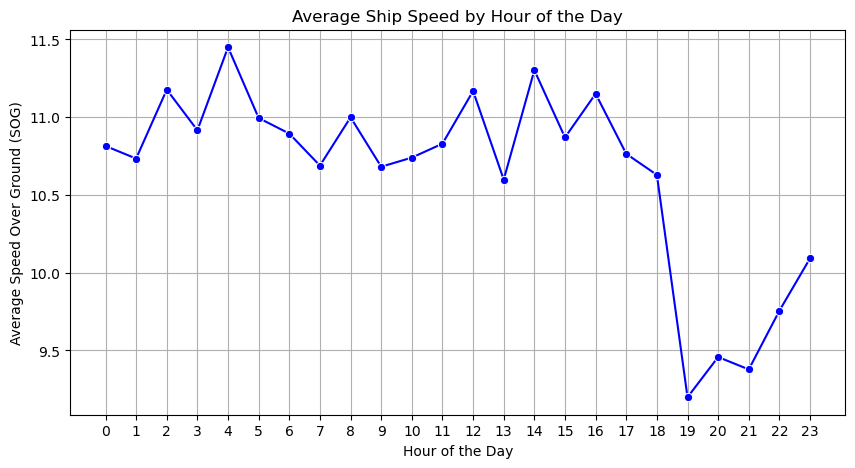

In [102]:
hourly_speed = df.groupby("Hour")["SOG"].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_speed.index, y=hourly_speed.values, marker="o", color="blue")
plt.title("Average Ship Speed by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Speed Over Ground (SOG)")
plt.xticks(range(0, 24))  # Show all hours on the x-axis
plt.grid()
plt.show()

In [115]:
df.to_csv("ship_movement_analysis.csv", index=False)

C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\760452642.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



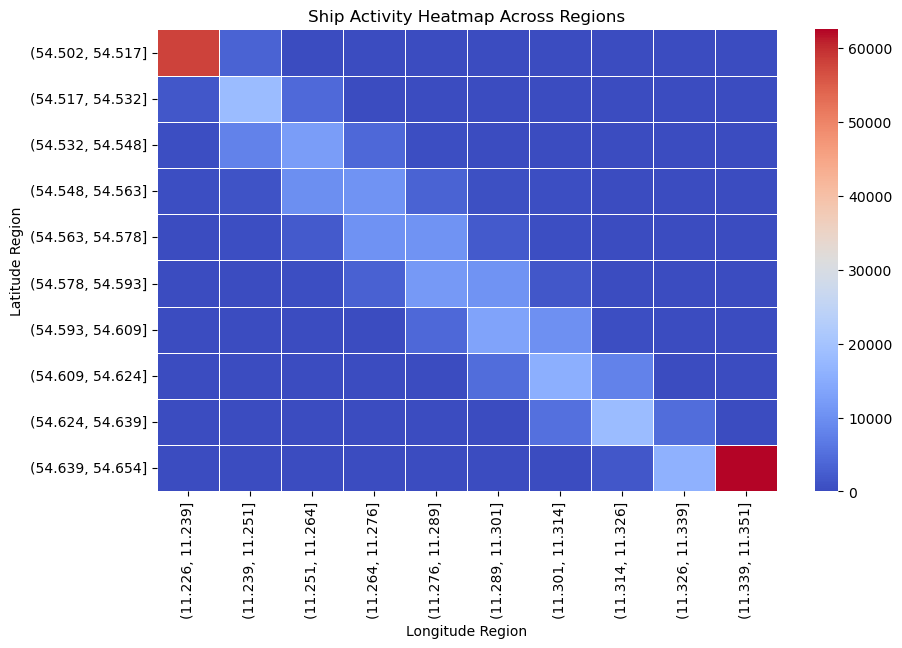

In [117]:
df["Lat_Region"] = pd.cut(df["Latitude"], bins=10)
df["Lon_Region"] = pd.cut(df["Longitude"], bins=10)

region_activity = df.groupby(["Lat_Region", "Lon_Region"])["MMSI"].count().reset_index()

region_pivot = region_activity.pivot(index="Lat_Region", columns="Lon_Region", values="MMSI")

plt.figure(figsize=(10, 6))
sns.heatmap(region_pivot, cmap="coolwarm", linewidths=0.5)
plt.title("Ship Activity Heatmap Across Regions")
plt.xlabel("Longitude Region")
plt.ylabel("Latitude Region")
plt.show()

C:\Users\abasu\AppData\Local\Temp\ipykernel_6832\1456365913.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



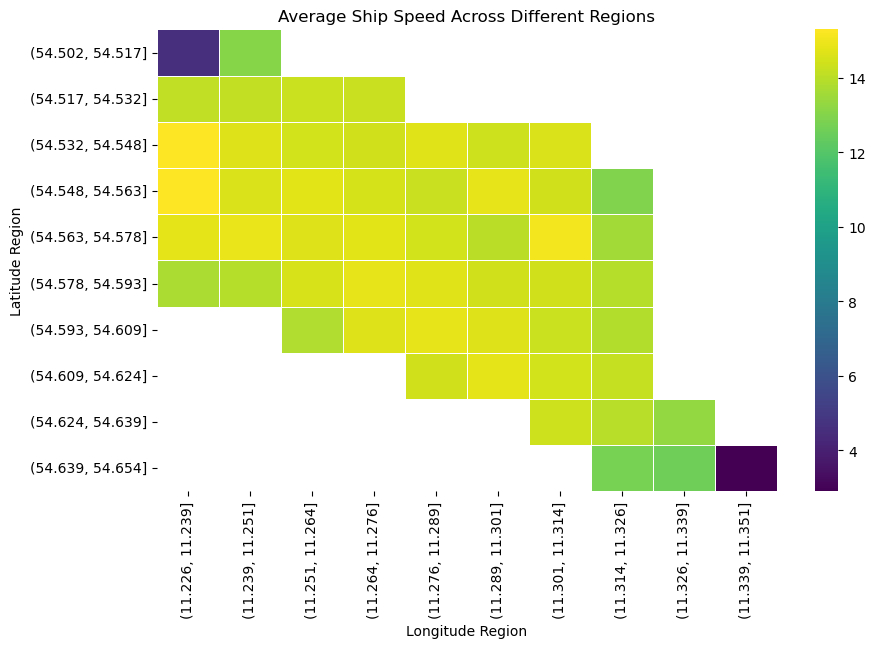

In [119]:
region_speed = df.groupby(["Lat_Region", "Lon_Region"])["SOG"].mean().reset_index()

region_speed_pivot = region_speed.pivot(index="Lat_Region", columns="Lon_Region", values="SOG")

plt.figure(figsize=(10, 6))
sns.heatmap(region_speed_pivot, cmap="viridis", linewidths=0.5)
plt.title("Average Ship Speed Across Different Regions")
plt.xlabel("Longitude Region")
plt.ylabel("Latitude Region")
plt.show()

In [62]:
hourly_activity = df.groupby("Hour")["MMSI"].nunique().reset_index()
daily_activity = df.groupby("Day_of_Week")["MMSI"].nunique().reset_index()
monthly_activity = df.groupby("Month")["MMSI"].nunique().reset_index()

hourly_activity.columns = ["Hour", "Active Ships"]
daily_activity.columns = ["Day of Week", "Active Ships"]
monthly_activity.columns = ["Month", "Active Ships"]

print("Hourly Ship Activity:\n", hourly_activity)
print("\nDaily Ship Activity:\n", daily_activity)
print("\nMonthly Ship Activity:\n", monthly_activity)


Hourly Ship Activity:
     Hour  Active Ships
0      0             3
1      1             3
2      2             3
3      3             3
4      4             3
5      5             3
6      6             3
7      7             3
8      8             3
9      9             3
10    10             3
11    11             3
12    12             3
13    13             3
14    14             3
15    15             3
16    16             3
17    17             3
18    18             3
19    19             3
20    20             3
21    21             3
22    22             3
23    23             3

Daily Ship Activity:
    Day of Week  Active Ships
0            0             3
1            3             3
2            6             3

Monthly Ship Activity:
    Month  Active Ships
0      1             3
1      2             3
2      3             3
3      4             3


In [66]:
df["Lat_Region"] = pd.cut(df["Latitude"], bins=10)
df["Lon_Region"] = pd.cut(df["Longitude"], bins=10)

region_ship_counts = df.groupby(["Lat_Region", "Lon_Region"])["MMSI"].nunique().reset_index()
region_ship_counts.columns = ["Latitude Region", "Longitude Region", "Ship Count"]

print(region_ship_counts)


     Latitude Region  Longitude Region  Ship Count
0   (54.502, 54.517]  (11.226, 11.239]           3
1   (54.502, 54.517]  (11.239, 11.251]           3
2   (54.502, 54.517]  (11.251, 11.264]           0
3   (54.502, 54.517]  (11.264, 11.276]           0
4   (54.502, 54.517]  (11.276, 11.289]           0
..               ...               ...         ...
95  (54.639, 54.654]  (11.289, 11.301]           0
96  (54.639, 54.654]  (11.301, 11.314]           0
97  (54.639, 54.654]  (11.314, 11.326]           3
98  (54.639, 54.654]  (11.326, 11.339]           3
99  (54.639, 54.654]  (11.339, 11.351]           3

[100 rows x 3 columns]


C:\Users\abasu\AppData\Local\Temp\ipykernel_14812\4020586897.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_ship_counts = df.groupby(["Lat_Region", "Lon_Region"])["MMSI"].nunique().reset_index()


In [68]:
df["Is_Stationary"] = df["SOG"] < 0.5

stationary_counts = df["Is_Stationary"].value_counts()

print("Stationary Ship Counts:\n", stationary_counts)


Stationary Ship Counts:
 Is_Stationary
False    294464
True      60350
Name: count, dtype: int64


Sharp Turns Ship Counts:
 Is_Taking_Sharp_Turns
False    354656
True        158
Name: count, dtype: int64


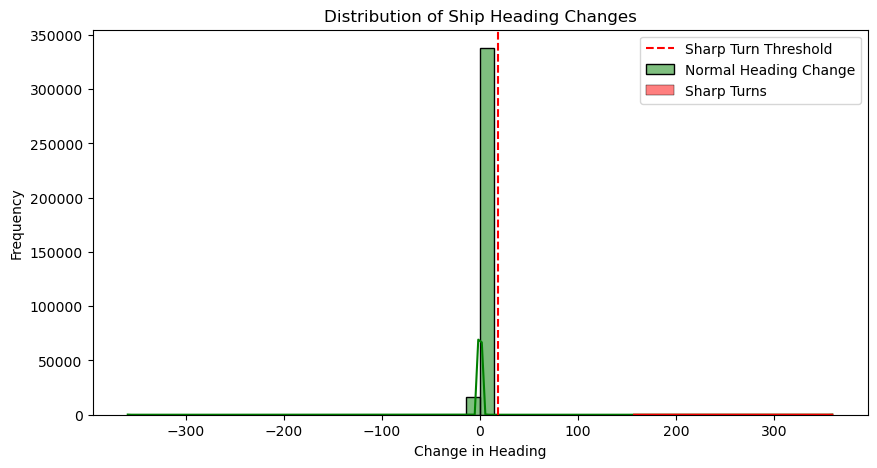

In [70]:
heading_threshold = df["Change_in_Heading"].mean() + 3 * df["Change_in_Heading"].std()

df["Is_Taking_Sharp_Turns"] = df["Change_in_Heading"] > heading_threshold

sharp_turns_counts = df["Is_Taking_Sharp_Turns"].value_counts()

print("Sharp Turns Ship Counts:\n", sharp_turns_counts)

plt.figure(figsize=(10, 5))
sns.histplot(df["Change_in_Heading"], bins=50, kde=True, color="green", label="Normal Heading Change")
sns.histplot(df[df["Is_Taking_Sharp_Turns"]]["Change_in_Heading"], bins=50, kde=True, color="red", label="Sharp Turns")
plt.axvline(heading_threshold, color="red", linestyle="dashed", label="Sharp Turn Threshold")
plt.title("Distribution of Ship Heading Changes")
plt.xlabel("Change in Heading")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Abnormal Speed Ship Counts:
 Is_Abnormal_Speed
False    354814
Name: count, dtype: int64


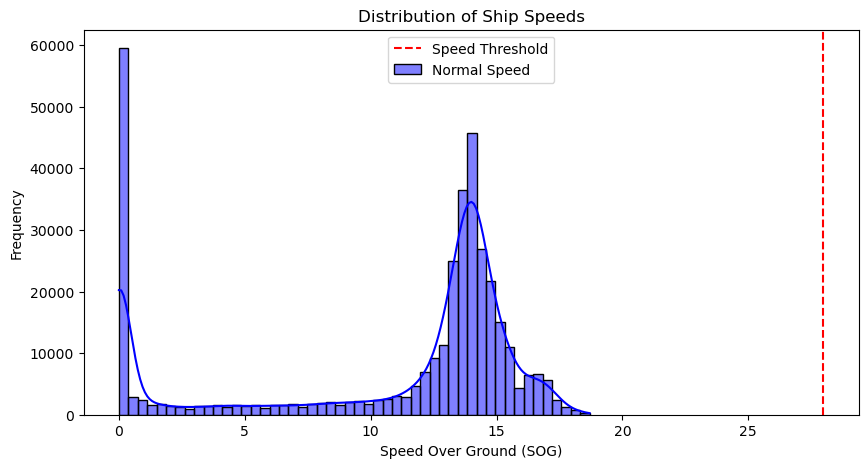

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

speed_threshold = df["SOG"].mean() + 3 * df["SOG"].std()

df["Is_Abnormal_Speed"] = df["SOG"] > speed_threshold

abnormal_speed_counts = df["Is_Abnormal_Speed"].value_counts()

print("Abnormal Speed Ship Counts:\n", abnormal_speed_counts)

plt.figure(figsize=(10, 5))
sns.histplot(df["SOG"], bins=50, kde=True, color="blue", label="Normal Speed")
sns.histplot(df[df["Is_Abnormal_Speed"]]["SOG"], bins=50, kde=True, color="red", label="Abnormal Speed")
plt.axvline(speed_threshold, color="red", linestyle="dashed", label="Speed Threshold")
plt.title("Distribution of Ship Speeds")
plt.xlabel("Speed Over Ground (SOG)")
plt.ylabel("Frequency")
plt.legend()
plt.show()
